# KL2 Data Processing & Analysis

In [64]:
%load_ext autoreload
%autoreload 2

## 1 Relabeling

### 1.1 Features Renaming & Preliminary Relabeling

The folder "Data Preprocessing" defines some rules to rename features as well as some preliminary relabeling of feature values.

This section load these rules and process the data as a first step.

In [65]:
# libraries, utility functions

import sys
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

def load_lookup_table(folder_path):
    '''
    "Data Preprocessing" folder contains a bunch of .xlsx's, each coming with one or multiple sheets.
    Each sheet is expected to have only 2 column.
    The first row is a mapping from original column name in collected data, to a more refined (?) variation.
    The rest of the rows are a mapping from field values on the questionnaire to an interpretable label, usually a string.
    If for some row there's no value at the second column, that means we are not interested in those feature values.
    '''
    column_map = {}
    lookup_table = {'columns': column_map} # `column_map`: map old column in original

    excel_paths = glob(os.path.join(folder_path, "*.xlsx"))
    for path in excel_paths:    # read each excel files
        xls = pd.ExcelFile(path)
        for sheet_name in xls.sheet_names:
            df = pd.read_excel(path, sheet_name=sheet_name, header=None)    # one df per sheet
            if df.shape[1] >= 2:  # Ensure at least two columns exist
                old_col_name, new_col_name = df.iloc[0, :2].str.strip()
                if pd.isna(old_col_name):
                    continue
                if pd.isna(new_col_name):
                    new_col_name = old_col_name
                column_map[old_col_name] = new_col_name
                relabel_map = dict(df.iloc[1:, :2].itertuples(index=False))
                lookup_table[new_col_name] = relabel_map
    # more: add two new feature names: 'diagnosis_b' and 'diagnosis_c'
    lookup_table['columns']['diagnosisb'] = 'diagnosis_b'
    lookup_table['columns']['diagnosisc'] = 'diagnosis_c'
    # set the mapping to the same as 'diagnosis'
    lookup_table['diagnosis_b'] = lookup_table['diagnosis']
    lookup_table['diagnosis_c'] = lookup_table['diagnosis']
        
    return lookup_table

def format_data(raw_data_path, lookup_table, keep_columns=True):
    df = pd.read_csv(raw_data_path, delimiter='|', low_memory=False)[:-1] # drop last row: summarizing # rows of the table
    df.iloc[:, 0] = df.iloc[:, 0].astype(float) # first column is coerced to int due to error caused by last special row 
    df.rename(columns=lookup_table['columns'], inplace=True)
    df.replace(lookup_table, inplace=True)
    if not keep_columns:
        columns = df.columns.intersection(lookup_table['columns'].values())
        df = df[columns]

    return df

# # Usage
# folder_path = "../data/Data Preprocessing/"
# raw_data_path = '../data/Original files/Cogan_eRD_RIC1_request.txt'  # Update this to your raw data file path
# output_path = '/path/to/output/renamed_data.xlsx'  # Update this to your desired output file path

# data_dict = load_data_dictionary(folder_path)
# relabeled_data = rename_columns(raw_data_path, data_dict, keep_columns=True)  # Set keep_columns to False if you want to drop columns not in the data dictionary

In [66]:
# load folder "Data Preprocessing" as a lookup table

folder_path = "./data/Data Preprocessing/"
raw_data_path = './data/Original files/Cogan_eRD_RIC1_request.txt'
lookup_table = load_lookup_table(folder_path)

lookup_table['columns']

{'diagnosis': 'diagnosis',
 'priorselfcare': 'selfcare_prior',
 'priorindoormobility': 'mobility_prior',
 'priorstairs': 'stairs_prior',
 'priorfunctionalcognition': 'func_cog_prior',
 'pdumanualwheelchair': 'wc_manual_prior',
 'pdumotorizedwheelchair': 'wc_motor_prior',
 'pdumechanicallift': 'mechlift_prior',
 'pduwalker': 'walker_prior',
 'pduorthoticsprosthetics': 'orth_pros_prior',
 'pdunone': 'no_device_prior',
 'eatingadm': 'eating_adm',
 'eatinggoal': 'eating_goal',
 'oralhygieneadm': 'oral_adm',
 'oralhygienegoal': 'oral_goal',
 'toiletinghygieneadm': 'toileting_adm',
 'toiletinghygienegoal': 'toileting_goal',
 'showerbatheadm': 'bathe_adm',
 'showerbathegoal': 'bathe_goal',
 'dressupperbodyadm': 'dress_upper_adm',
 'dressupperbodygoal': 'dress_upper_goal',
 'dresslowerbodyadm': 'dress_lower_adm',
 'dresslowerbodygoal': 'dress_lower_goal',
 'dondofffootwearadm': 'footwear_adm',
 'dondofffootweargoal': 'footwear_goal',
 'rollleftrightadm': 'roll_lr_adm',
 'rollleftrightgoal': 'r

In [67]:
# preprocess data with lookup table

df = format_data(raw_data_path, lookup_table, keep_columns=True)

df

KeyboardInterrupt: 

In [ ]:
# have a look at unique diagnosis
print("# of unique diagnosis:", df['diagnosis'].unique().size)
df['diagnosis'].unique()

In [ ]:
# save preprocessed data

df.to_csv('./data/Cleaned files/Cogan_1_1.csv', index=False)

In [ ]:
# save lookup table
import pickle

with open("./data/Cleaned files/lookup_table.pkl", 'wb') as f:
    pickle.dump(lookup_table, f)

#### Examine some features of interest here

In [ ]:
lookup_table['language']

### 1.2 Add Aggregated Outcomes 

In [ ]:
# load formated dataframe and see all feature names

import pandas as pd
import pickle
from tabulate import tabulate
import numpy as np

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_1_1.csv', low_memory=False)
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)

feature_names = [*df.head()]
print("total # of features:", len(feature_names))

print(tabulate(enumerate(feature_names), headers=["Index", "Name"], tablefmt="grid"))

total # of features: 449
+---------+--------------------------------+
|   Index | Name                           |
+=========+================================+
|       0 | sex                            |
+---------+--------------------------------+
|       1 | marital_status                 |
+---------+--------------------------------+
|       2 | admityear                      |
+---------+--------------------------------+
|       3 | admitclass                     |
+---------+--------------------------------+
|       4 | admit_from                     |
+---------+--------------------------------+
|       5 | prehospital_living             |
+---------+--------------------------------+
|       6 | prehospital_living_with        |
+---------+--------------------------------+
|       7 | payor_primary                  |
+---------+--------------------------------+
|       8 | payor_secondary                |
+---------+--------------------------------+
|       9 | impgroupadmit     

In [ ]:
# define outcome features
selfcare_items = [
    "eating",
    "oral",
    "toileting",
    "bathe",
    "dress_upper",
    "dress_lower",
    "footwear",
]
mobility_items = [
    "roll_lr",
    "sit_lying",
    "lying_sit",
    "sit_stand",
    "bed_chair",
    "toilet_trans",
    "car_trans",
    "walk10ft",
    "walk50ft",
    "walk150ft",
    "walk10ft_uneven",
    "walk1step",
    "walk4step",
    "walk12step",
    "pickup"
]
print("# of selfcare items:", len(selfcare_items))
print("# of mobility items:", len(mobility_items))

# of selfcare items: 7
# of mobility items: 15


In [ ]:
# define ordinal sum to measure mapping
selfcare_table = {
    7: 19.65,
    8: 24.7,
    9: 27.64,
    10: 29.69,
    11: 31.44,
    12: 33.02,
    13: 34.46,
    14: 35.78,
    15: 36.97,
    16: 38.04,
    17: 38.98,
    18: 39.84,
    19: 40.62,
    20: 41.35,
    21: 42.05,
    22: 42.73,
    23: 43.39,
    24: 44.07,
    25: 44.77,
    26: 45.52,
    27: 46.33,
    28: 47.25,
    29: 48.33,
    30: 49.64,
    31: 51.28,
    32: 53.37,
    33: 56.1,
    34: 59.86,
    35: 65.47,
    36: 71.86,
    37: 76.96,
    38: 81.08,
    39: 84.76,
    40: 88.57,
    41: 93.54,
    42: 100.64,
}
mobility_table = {
    15: 4.86,
    16: 11.07,
    17: 14.3,
    18: 16.1,
    19: 17.35,
    20: 18.34,
    21: 19.16,
    22: 19.89,
    23: 20.54,
    24: 21.14,
    25: 21.71,
    26: 22.26,
    27: 22.79,
    28: 23.3,
    29: 23.81,
    30: 24.31,
    31: 24.81,
    32: 25.31,
    33: 25.82,
    34: 26.32,
    35: 26.82,
    36: 27.32,
    37: 27.83,
    38: 28.33,
    39: 28.82,
    40: 29.32,
    41: 29.81,
    42: 30.29,
    43: 30.77,
    44: 31.25,
    45: 31.72,
    46: 32.18,
    47: 32.65,
    48: 33.11,
    49: 33.57,
    50: 34.02,
    51: 34.48,
    52: 34.93,
    53: 35.39,
    54: 35.85,
    55: 36.32,
    56: 36.88,
    57: 37.28,
    58: 37.77,
    59: 38.28,
    60: 38.81,
    61: 39.36,
    62: 39.94,
    63: 40.56,
    64: 41.21,
    65: 41.92,
    66: 42.68,
    67: 43.52,
    68: 44.46,
    69: 45.53,
    70: 46.75,
    71: 48.17,
    72: 49.83,
    73: 51.76,
    74: 53.98,
    75: 56.42,
    76: 58.93,
    77: 61.36,
    78: 63.64,
    79: 65.73,
    80: 67.83,
    81: 69.82,
    82: 71.78,
    83: 73.76,
    84: 75.79,
    85: 77.91,
    86: 80.21,
    87: 82.62,
    88: 86.36,
    89: 90.90,
    90: 98.38
}


In [ ]:
# safe buffer
last_df = df

In [ ]:
# for outcome features, replace invalid responses as nan and count invalid samples
df = last_df.copy()
selfcare_columns = [item + '_adm' for item in selfcare_items] + [item + '_dc' for item in selfcare_items]
mobility_columns = [item + '_adm' for item in mobility_items] + [item + '_dc' for item in mobility_items]

subset_columns = [item + '_adm' for item in selfcare_items+mobility_items]
subset_columns += [item + '_dc' for item in selfcare_items+mobility_items]
df.loc[:, subset_columns] = df.loc[:, subset_columns].replace({
    'Refused': np.nan,
    'Not_applicable': np.nan,
    'Not_attempted': np.nan,
    'Safety': np.nan
})
print(df[subset_columns].isna().sum(axis=0))
# df = df.dropna(subset=selfcare_columns)
# df = df.dropna(subset=subset_columns)
# print("# of valid patients changed from", len(last_df), "to", len(df))

eating_adm              2474
oral_adm                1387
toileting_adm            984
bathe_adm               4420
dress_upper_adm         1750
dress_lower_adm         1343
footwear_adm             958
roll_lr_adm             1229
sit_lying_adm           1430
lying_sit_adm           1433
sit_stand_adm           3711
bed_chair_adm           2403
toilet_trans_adm        5618
car_trans_adm          24704
walk10ft_adm           15365
walk50ft_adm           24103
walk150ft_adm          32291
walk10ft_uneven_adm    31558
walk1step_adm          25778
walk4step_adm          29097
walk12step_adm         37282
pickup_adm             29537
eating_dc               3732
oral_dc                 3152
toileting_dc            3077
bathe_dc                3336
dress_upper_dc          3124
dress_lower_dc          3099
footwear_dc             3135
roll_lr_dc              3199
sit_lying_dc            3145
lying_sit_dc            3142
sit_stand_dc            3553
bed_chair_dc            3125
toilet_trans_d

In [ ]:
# calculate 4 measures

DO_IMPUTE_MISSING_OUTCOMES = True

if DO_IMPUTE_MISSING_OUTCOMES:
    df.loc[:, subset_columns] = df.loc[:, subset_columns].fillna(1) # replace NaNs with 1 ordinal

inverse_lookup = {v:k for k,v in lookup_table[selfcare_items[0]+'_adm'].items()}
print(inverse_lookup)

selfcare_sum_adm = df[[item + '_adm' for item in selfcare_items]].replace(inverse_lookup).sum(axis=1, skipna=False)
# print(selfcare_sum_adm[:10])
selfcare_sum_dc = df[[item + '_dc' for item in selfcare_items]].replace(inverse_lookup).sum(axis=1, skipna=False)
print("selfcare sum adm nan count:", np.sum(np.isnan(selfcare_sum_adm)))
print("selfcare sum dc nan count:", np.sum(np.isnan(selfcare_sum_dc)))

selfcare_measure_adm = selfcare_sum_adm.map(selfcare_table)
# print(selfcare_measure_adm[:10])
selfcare_measure_dc = selfcare_sum_dc.map(selfcare_table)
print("selfcare measure adm nan count:", np.sum(pd.isna(selfcare_measure_adm).to_numpy()))
print("selfcare measure dc nan count:", np.sum(pd.isna(selfcare_measure_dc).to_numpy()))

mobility_sum_adm = df[[item + '_adm' for item in mobility_items]].replace(inverse_lookup).sum(axis=1, skipna=False)
mobility_sum_dc = df[[item + '_dc' for item in mobility_items]].replace(inverse_lookup).sum(axis=1, skipna=False)
print("mobility sum adm nan count:", np.sum(np.isnan(mobility_sum_adm)))
print("mobility sum dc nan count:", np.sum(np.isnan(mobility_sum_dc)))
mobility_measure_adm = mobility_sum_adm.map(mobility_table)
mobility_measure_dc = mobility_sum_dc.map(mobility_table)
print("mobility measure adm nan count:", np.sum(pd.isna(mobility_measure_adm).to_numpy()))
print("mobility measure dc nan count:", np.sum(pd.isna(mobility_measure_dc).to_numpy()))

{'Independent': 6, 'Setup': 5, 'Supervised': 4, 'Mod_assist': 3, 'Max_assist': 2, 'Dependent': 1, 'Refused': 7, 'Not_applicable': 9, 'Not_attempted': 10, 'Safety': 88}
selfcare sum adm nan count: 0
selfcare sum dc nan count: 0
selfcare measure adm nan count: 0
selfcare measure dc nan count: 0
mobility sum adm nan count: 0
mobility sum dc nan count: 0
mobility measure adm nan count: 0
mobility measure dc nan count: 0


In [ ]:
# add outcome measure columns to the df
df['selfcare_measure_adm'] = selfcare_measure_adm
df['selfcare_measure_dc'] = selfcare_measure_dc
df['mobility_measure_adm'] = mobility_measure_adm
df['mobility_measure_dc'] = mobility_measure_dc

# add two delta measure columns, just for quick filtering out valid samples (measures @adm&dc are both valid)
df['selfcare_measure_delta'] = (selfcare_measure_dc - selfcare_measure_adm).round(2)
df['mobility_measure_delta'] = (mobility_measure_dc - mobility_measure_adm).round(2)
print("# of invalid samples for selfcare:", np.isnan(df['selfcare_measure_delta']).sum(), " out of", len(df))
print("# of invalid samples for mobility:", np.isnan(df['mobility_measure_delta']).sum(), " out of", len(df))

# of invalid samples for selfcare: 0  out of 43745
# of invalid samples for mobility: 0  out of 43745


In [ ]:
# save processed data with 6 extra columns

df.to_csv('./data/Cleaned files/Cogan_1_2.csv', index=False)

### 1.3 Relabel & Precess Features


In [ ]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_1_2.csv', low_memory=False)
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)

feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

print(tabulate([(index, name, feature_dtypes[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype"], tablefmt="grid"))
categorical_feature_set = set()
numeric_feature_set = set()
ranked_int_feature_set = set()
binary_feature_set = set()

total # of features: 455
+---------+--------------------------------+---------+
|   Index | Name                           | Dtype   |
+=========+================================+=========+
|       0 | sex                            | object  |
+---------+--------------------------------+---------+
|       1 | marital_status                 | object  |
+---------+--------------------------------+---------+
|       2 | admityear                      | float64 |
+---------+--------------------------------+---------+
|       3 | admitclass                     | float64 |
+---------+--------------------------------+---------+
|       4 | admit_from                     | object  |
+---------+--------------------------------+---------+
|       5 | prehospital_living             | object  |
+---------+--------------------------------+---------+
|       6 | prehospital_living_with        | object  |
+---------+--------------------------------+---------+
|       7 | payor_primary               

In [ ]:
# set column 'id' as index
df['id'] = df['id'].astype(int)

df.set_index('id', inplace=True)
print(df)

          sex marital_status  admityear  admitclass  \
id                                                    
1      female        Married     2023.0         1.0   
2        male        Married     2023.0         1.0   
3        male        Married     2023.0         1.0   
4      female        Widowed     2022.0         1.0   
5      female            NaN     2023.0         1.0   
...       ...            ...        ...         ...   
43741  female        Widowed     2022.0         1.0   
43742  female  Never married     2022.0         NaN   
43743  female        Married     2022.0         1.0   
43744    male        Married     2022.0         1.0   
43745  female        Widowed     2023.0         1.0   

                        admit_from prehospital_living prehospital_living_with  \
id                                                                              
1      Short-term general hospital               Home                  Family   
2      Short-term general hospital       

#### Column: "maritalstatus"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process column "marital status": (currently) Married or Unmarried
df = last_df.copy() # always work on a fresh copy of last step's output
print(df["marital_status"].unique())
df["marital_status"] = df["marital_status"].replace(['Widowed', 'Divorced', 'Separated', 'Never married'], 'Unmarried')
print(df["marital_status"].unique())

['Married' 'Widowed' nan 'Divorced' 'Separated' 'Never married']
['Married' 'Unmarried' nan]


#### Column: "admitclass"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process column "admitclass"
df = last_df.copy() # always work on a fresh copy of last step's output
print(df["admitclass"].unique())
df['admitclass'] = df['admitclass'].astype('Int32')
df['admitclass'] = df['admitclass'].map({
    1: 'Initial',
    2: 'Other',
    3: 'Readmission',
    4: 'Other',
    5: 'Other'
})
print(df["admitclass"].unique())

[ 1.  4.  3. nan  5.  2.]
['Initial' 'Other' 'Readmission' nan]


#### Column: "admit_from"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process column "admit_from"
df = last_df.copy() # always work on a fresh copy of last step's output
print(df["admit_from"].unique())
df['admit_from'] = df['admit_from'].replace({
    'Home': 'Home-based',
    'Home health service': 'Home-based',
    'Hospice (home)': 'Home-based',
    'Short-term general hospital': 'Short-term hospital',
    'Skilled nursing facility': 'Other facility',
    'Long-term care hospital': 'Other facility',
    'Another IRF': 'Other facility',
    'Intermediate care': 'Other facility',
    'Critical access hospital': 'Other facility',
    'Medicaid nursing facility': 'Other facility',
    'Inpatient psychiatric facility': 'Other facility',
    'Swing bed': 'Other facility',
    'Hospice (facility)': 'Other facility',
    'Not listed': 'Other facility'
})
print(df["admit_from"].unique())

['Short-term general hospital' 'Home' 'Skilled nursing facility'
 'Home health service' 'Long-term care hospital' 'Not listed'
 'Another IRF' 'Intermediate care' 'Critical access hospital'
 'Medicaid nursing facility' 'Inpatient psychiatric facility' 'Swing bed'
 'Hospice (home)' 'Hospice (facility)']
['Short-term hospital' 'Home-based' 'Other facility']


#### Column: "prehospital_living" and "discharge_living"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process column "prehospital_living" & "discharge_living"
df = last_df.copy() # always work on a fresh copy of last step's output
# print(lookup_table['columns']["prehospitallivingsetting"])
print(df["prehospital_living"].unique())
print(df["discharge_living"].unique())
living_dict = {
    'Home': 'Home',
    'Home health service': 'Home',
    'Inpatient psychiatric facility': 'Facility',
    'Intermediate care': 'Facility',
    'Skilled nursing facility': 'Facility',
    'Medicaid nursing facility': 'Facility',
    'Short-term general hospital': 'Facility',
    'Long-term care hospital': 'Facility',
    'Another IRF': 'Facility',
    'Not listed': 'Facility',
    'Hospice (facility)': 'Facility',
    'Hospice (home)': 'Home',
    'Swing bed': 'Facility',
    'Critical access hospital': 'Facility',
}
df['prehospital_living'] = df['prehospital_living'].replace(living_dict)
df['discharge_living'] = df['discharge_living'].replace(living_dict)
print(df["prehospital_living"].unique())
print(df["discharge_living"].unique())

['Home' 'Inpatient psychiatric facility' 'Home health service'
 'Intermediate care' 'Skilled nursing facility'
 'Medicaid nursing facility' 'Short-term general hospital' 'Not listed'
 'Long-term care hospital' 'Another IRF']
['Home health service' 'Home' 'Skilled nursing facility'
 'Short-term general hospital' 'Hospice (facility)'
 'Medicaid nursing facility' 'Hospice (home)' 'Swing bed' 'Not listed'
 'Intermediate care' 'Another IRF' nan 'Inpatient psychiatric facility'
 'Long-term care hospital' 'Critical access hospital']
['Home' 'Facility']
['Home' 'Facility' nan]


#### Column: "heightinches" and "weightpounds"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process heights and weights: "0."s should be replaces with NA
df = last_df.copy() # always work on a fresh copy of last step's output
print(df["heightinches"].unique())
print(df["weightpounds"].unique())
df['heightinches'] = df['heightinches'].replace(0, np.nan)
df['weightpounds'] = df['weightpounds'].replace(0, np.nan)
print(df["heightinches"].unique())
print(df["weightpounds"].unique())

[70. 69. 64. 72. 62. 61. 71. 67. 65. 68. 63. 74. 73. 60. 76. 58. 59. 66.
 75. 57. 77. 37. 56. 78.  0. 49. 54. 28. 47. 48. 23. 80. 55.  2. 99. 82.
 84. 30. 53. 79. 42. 26. 46. 39. 44.  5. 51. 83. 29. 19. 43. 13. 35. 45.
 10.  1. 85. 50. 81. 41. 52. 32. 27. 25. 18. 24.  6. 36. 38.]
[161. 153. 175. 120. 140. 169. 155. 201. 178. 189. 234. 142. 196. 135.
 174. 177. 132. 171. 138. 172. 162. 209. 159. 198. 190. 181. 130. 206.
 184. 291. 214. 116. 148. 158. 194. 249. 131.  95. 154. 127. 157. 104.
 108. 203. 118. 264. 193. 272. 199. 235. 167. 141. 218. 195. 145. 126.
 103. 183. 237.  97. 151. 230. 265. 205. 251. 146. 233. 204. 240. 236.
 176. 187. 210. 280.  82. 229. 223. 227. 165. 270. 310. 341. 191. 185.
 425. 182. 102. 128. 137. 220. 106. 245. 134. 147. 160. 222. 283. 188.
 129. 156. 168. 125. 119. 302. 377. 152. 306. 232. 266.  76. 208. 219.
 143. 164. 105. 166. 144. 478.  30. 207. 170. 224. 225. 180. 217. 113.
 200. 226. 296. 215. 139. 122. 248. 107. 100. 114.   0. 121. 321. 149.
 136. 273

#### Column: all treatment amount columns

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process all treatment amount columns: if value > 600, drop
df = last_df.copy() # always work on a fresh copy of last step's output

# List of the columns to check for values greater than 600
treatment_amount_columns = [
    "ptindweek1", "ptconweek1", "ptgrpweek1", "ptcoweek1",
    "otindweek1", "otconweek1", "otgrpweek1", "otcoweek1",
    "slpindweek1", "slpconweek1", "slpgrpweek1", "slpcoweek1",
    "ptindweek2", "ptconweek2", "ptgrpweek2", "ptcoweek2",
    "otindweek2", "otconweek2", "otgrpweek2", "otcoweek2",
    "slpindweek2", "slpconweek2", "slpgrpweek2", "slpcoweek2"
]

print(f"# of rows before: {df.shape[0]}")

df = df[~(df[treatment_amount_columns] > 600).any(axis=1)]

print(f"# of rows after: {df.shape[0]}")


# of rows before: 43745
# of rows after: 42938


#### Column: "transport_lack"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process "transport_lack": group up 5 related columns
df = last_df.copy() # always work on a fresh copy of last step's output

print(df["transport_lack"].unique())
print(df["transport_lack_med"].unique())
print(df["transport_lack_nonmed"].unique())
print(df["transport_lack_unable"].unique())
print(df["transport_lack_declined"].unique())

df.loc[(df['transport_lack_unable'] == 'Yes') | (df['transport_lack_declined'] == 'Yes'), 'transport_lack'] = np.nan
df.loc[(df['transport_lack_med'] == 'Yes') | (df['transport_lack_nonmed'] == 'Yes'), 'transport_lack'] = 'Yes'

print(df["transport_lack"].unique())

['No' nan]
[nan 'Yes']
[nan 'Yes']
[nan 'Yes']
[nan 'Yes']
['No' nan 'Yes']


#### Column: "language"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process column "language": English or Non-English
df = last_df.copy() # always work on a fresh copy of last step's output

categorical_feature_set.add('language')

print(df['language'].unique())
df['language'] = df['language'].str.contains('eng|enlish', case=False, na=False)
df['language'] = df['language'].map({True: 'English', False: 'Non-English'})
print(df['language'].unique())

['English' 'ENGLISH' 'Spanish' 'Other' 'eng' 'english' 'spanish' 'SPANISH'
 'Vietnamese' 'Unknown' 'Polish' 'English and Spanish' 'Creole' 'Eng'
 'MANDARIN' 'Cambodia' 'Chinese' 'Korean' 'Englissh' 'HINDI' 'Enlglish'
 'POLISH' 'Sindhi/Urdu then English' 'French' 'Farsi' 'Panjabi' 'Mandarin'
 'Japanese' 'Malayalam' 'Ghana' 'Cambodian' 'ENLGISH' 'Indonesian'
 'tagalog' 'Swahili' 'Estonian' 'Portuguese' 'Cantonese'
 'Chinese, Mandarin' 'gujarati' 'German' 'other' 'Hmong' 'English/Spanish'
 'Russian' 'Englsih' 'Karen' 'Arabic' 'CREOLE' 'Undetermined' 'Gujarati'
 'Urdu' 'BANGLADESH' 'Hindi' 'Tagalog' 'TOISAN' 'Spanish and English'
 'Chinese - Canto' 'korean' 'creole' 'ASL' 'WHITE' 'Italian'
 'ENGLISH/TURKISH' 'Haitian' 'TAGALOG' 'en' 'CANTONESE' 'ENglish'
 'CHINESE' 'Serbian' 'Ukrainian' 'Persian' 'Swedish' 'English, Spanish'
 'Enbglish' 'Bosnian' 'Albanian' 'LAO' 'chinese' 'Chinese - Manda'
 'Slovak' 'French Creole' 'English, Other' 'ukranian' 'ENGLSIH' 'Enlish'
 'Chuukese' 'VIETNAMESE' 'A

#### Column: "hispanic"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process column "hispanic" (ethnicity): English or Non-English
df = last_df.copy() # always work on a fresh copy of last step's output

categorical_feature_set.add('hispanic')
print("nan count before:", pd.isna(df['hispanic']).sum())

# 1. fill 'Yes' where any of the hispanic subcategories are 'Yes'
hispanic_yes_cols = ['hispanic_mexican', 'hispanic_puertorican', 'hispanic_cuban', 'hispanic_other']
df.loc[df['hispanic'].isna() & (df[hispanic_yes_cols] == 'Yes').any(axis=1), 'hispanic'] = 'Yes'

# 2. fill 'No' where hispanic_unable or hispanic_declined are 'Yes'
hispanic_no_cols = ['hispanic_unable', 'hispanic_declined']
df.loc[df['hispanic'].isna() & (df[hispanic_no_cols] == 'Yes').any(axis=1), 'hispanic'] = 'No'

# 3. for rows where 'hispanic' is still NaN, fill it with 'No'
df['hispanic'].fillna('No', inplace=True)

print("nan count after:", pd.isna(df['hispanic']).sum())
print(df['hispanic'].unique())


nan count before: 4404
nan count after: 0
['No' 'Yes']


#### Column: "race"

In [ ]:
# safe buffer
last_df = df

In [ ]:
# process column "race"
df = last_df.copy() # always work on a fresh copy of last step's output

categorical_feature_set.add('race')

# grouping east asians (chinese, japanese, korean)
race_is_east_asian = df[['race_chinese', 'race_japanese', 'race_korean']].eq('Yes').any(axis=1) # bool column

# grouping other asians (filipino, vietnamese, asian other)
race_is_asian_other = df[['race_filipino', 'race_vietnamese', 'race_asianother']].eq('Yes').any(axis=1)

# grouping pacific islanders (hawaiian, guam, samoan, pacific islander other)
race_is_pacific_islander = df[['race_hawaiian', 'race_guam', 'race_samoan', 'race_pacificislander_other']].eq('Yes').any(axis=1)

# asian indian mapping
race_is_asian_indian = df['race_asianindian'].eq('Yes')

# grouping unknown (unable, declined, none of the above)
race_is_unknown = df[['race_unable', 'race_declined', 'race_noneoftheabove']].eq('Yes').any(axis=1)

# keeping the original race columns (race_white, race_black, race_alaskan) as is but casting them to binary
race_is_white = df['race_white'].eq('Yes')
race_is_black = df['race_black'].eq('Yes')
race_is_alaskan = df['race_alaskan'].eq('Yes')

df['race'] = np.nan
df['race'] = df['race'].astype('object')

df.loc[race_is_white, 'race'] = 'White'
df.loc[race_is_black, 'race'] = 'Black'
df.loc[race_is_alaskan, 'race'] = 'Alaskan'
df.loc[race_is_asian_indian, 'race'] = 'Asian_Indian'
df.loc[race_is_east_asian, 'race'] = 'East_Asian'
df.loc[race_is_asian_other, 'race'] = 'Southeast_Asian'
df.loc[race_is_pacific_islander, 'race'] = 'Pacific_islander'
df.loc[race_is_unknown, 'race'] = 'Unknown'

# fill any remaining NaNs with 'Unknown' if no condition matched
df['race'].fillna('Unknown', inplace=True)

print("nan count after:", pd.isna(df['race']).sum())
print(df['race'].unique())


nan count after: 0
['White' 'Black' 'Unknown' 'Southeast_Asian' 'Alaskan' 'Asian_Indian'
 'East_Asian' 'Pacific_islander']


#### Column: all bool features
**NaNs**: There shouldn't be any NaN left after processing.

In [ ]:
# safe buffer
last_df = df

In [ ]:
# bool features are generally recorded as "Yes" / "No" in raw data; covert to 0 / 1
df = last_df.copy() # always work on a fresh copy of last step's output

binary_features = [
    "arthritis",
    # "transport_lack_med",
    # "transport_lack_nonmed",
    "conduct_bims",
    "conduct_sams",
    "sams_season",
    "sams_room",
    "sams_names",
    "sams_hosp",
    "sams_none_above",
    "acute_mental_change",
    "wc_manual_prior",
    "wc_motor_prior",
    "mechlift_prior",
    "walker_prior",
    "orth_pros_prior",
    "no_device_prior",
    "wc_user",
    "pvd_comorbid",
    "diabetes_comorbid",
    "nutrition_parenteral_adm",
    "nutrition_tube_adm",
    "nutrition_mech_diet_adm",
    "nutrition_ther_diet_adm",
    "antipsychotic_taking_adm",
    "antipsychotic_ind_adm",
    "anticoagulant_taking_adm",
    "anticoagulant_ind_adm",
    "antibiotic_taking_adm",
    "antibiotic_ind_adm",
    "opioid_taking_adm",
    "opioid_ind_adm",
    "antiplatelet_taking_adm",
    "antiplatelet_ind_adm",
    "hypoglycemic_taking_adm",
    "hypoglycemic_ind_adm",
    "chemo_adm",
    "chemo_iv_adm",
    "chemo_oral_adm",
    "chemo_other_adm",
    "radiation_adm",
    "oxygen_adm",
    "oxygen_cont_adm",
    "oxygen_int_adm",
    "oxygen_high_adm",
    "suctioning_adm",
    "suctioning_sched_adm",
    "suctioning_asneeded_adm",
    "trach_adm",
    "vent_invasive_adm",
    "vent_noninvasive_adm",
    "vent_bipap_adm",
    "vent_cpap_adm",
    "meds_iv_adm",
    "meds_iv_vasoactive_adm",
    "meds_iv_antibiotic_adm",
    "meds_iv_anticoagulant_adm",
    "meds_iv_other_adm",
    "transfusions_adm",
    "dialysis_adm",
    "hemodialysis_adm",
    "peritoneal_dialysis_adm",
    "iv_access_adm",
    "iv_access_periph_adm",
    "iv_access_mid_adm",
    "iv_access_cent_adm",
]
for name in binary_features:
    binary_feature_set.add(name)
    print(f"----------working on: {name}----------")
    df[name] = df[name].apply(lambda x: x.lower() if isinstance(x, str) else x) # lower-casify first
    uniques = set(df[name].unique())
    print("uniques before:", uniques)
    print("dtype before:", df[name].dtype)
    print("nan count before:", pd.isna(df[name]).sum())
    if uniques == {0, 1}: # already processed
        continue
    if name == "conduct_sams":
        df[name].fillna("yes", inplace=True)
        df[name].replace({
            "yes": 1,
            "no": 0,
        }, inplace=True)
    elif name in {"sams_season","sams_room","sams_names","sams_hosp"}: # default: yes for all those completed BIMS
        df[name].replace({
            "no": 0,
            "yes": 1,
            np.nan: 1,
        }, inplace=True)
        df[name] = df[name].astype('int64')
    elif name == "sams_none_above":
        df[name].replace({
            "no": 0,
            "yes": 1,
            np.nan: 0,
        }, inplace=True)
        df[name] = df[name].astype('int64')
    elif '_ind_' in name:
        df[name].replace({
            "no": 0,
            "yes": 1,
            np.nan: 0,
        }, inplace=True)
        df[name] = df[name].astype('int64')
    else: # default behavior
        if uniques == {np.nan, "yes"}:
            df[name].fillna("no", inplace=True)
        elif uniques == {np.nan, "no"}:
            df[name].fillna("yes", inplace=True)
        elif uniques != {"yes", "no"}:
            raise Exception(f"{name} is not a binary feature")
        df[name].replace({
            "yes": 1,
            "no": 0,
        }, inplace=True)
    print("uniques after:", df[name].unique())
    if set(df[name].unique()) != {0, 1}:
        raise Exception(f"{name} is not well-formated, double check!")
    print("dtype after:", df[name].dtype)
    print("nan count after:", pd.isna(df[name]).sum())

----------working on: arthritis----------
uniques before: {'yes', 'no'}
dtype before: object
nan count before: 0
uniques after: [0 1]
dtype after: int64
nan count after: 0
----------working on: conduct_bims----------
uniques before: {'yes', 'no'}
dtype before: object
nan count before: 0
uniques after: [1 0]
dtype after: int64
nan count after: 0
----------working on: conduct_sams----------
uniques before: {nan, 'yes', 'no'}
dtype before: object
nan count before: 3837
uniques after: [1 0]
dtype after: int64
nan count after: 0
----------working on: sams_season----------
uniques before: {nan, 'yes', 'no'}
dtype before: object
nan count before: 38280
uniques after: [0 1]
dtype after: int64
nan count after: 0
----------working on: sams_room----------
uniques before: {nan, 'yes', 'no'}
dtype before: object
nan count before: 38280
uniques after: [0 1]
dtype after: int64
nan count after: 0
----------working on: sams_names----------
uniques before: {nan, 'yes', 'no'}
dtype before: object
nan cou

#### Column: all ranked integer features
**NaNs**: Leave them alone. Different imputation strategies can be applied later.

In [ ]:
# safe buffer
last_df = df

In [ ]:
# each case may need separate handling
df = last_df.copy() # always work on a fresh copy of last step's output

ranked_int_features = [
    "admityear",
    "hearing_adm",
    "vision_adm",
    "health_lit_adm",
    "expression_adm",
    "understand_verbal_adm",
    "bims_3words",
    "bims_year",
    "bims_month",
    "bims_day",
    "bims_recall_sock",
    "bims_recall_blue",
    "bims_recall_bed",
    "bims_total",
    "low_interest_adm",
    "low_interest_freq_adm",
    "depressed_adm",
    "depressed_freq_adm",
    "sleep_trouble_adm",
    "sleep_trouble_freq_adm",
    "tired_adm",
    "tired_freq_adm",
    "appetite_adm",
    "appetite_freq_adm",
    "feel_bad_adm",
    "feel_bad_freq_adm",
    "concentrate_adm",
    "concentrate_freq_adm",
    "slowfast_adm",
    "slowfast_freq_adm",
    "selfharm_adm",
    "selfharm_freq_adm",
    "mood_total_adm",
    "socisolation_adm",
    "selfcare_prior",
    "mobility_prior",
    "stairs_prior",
    "func_cog_prior",
    "eating_adm",
    "oral_adm",
    "toileting_adm",
    "bathe_adm",
    "dress_upper_adm",
    "dress_lower_adm",
    "footwear_adm",
    "roll_lr_adm",
    "sit_lying_adm",
    "lying_sit_adm",
    "sit_stand_adm",
    "bed_chair_adm",
    "toilet_trans_adm",
    "car_trans_adm",
    "walk10ft_adm",
    "walk50ft_adm",
    "walk150ft_adm",
    "walk10ft_uneven_adm",
    "walk1step_adm",
    "walk4step_adm",
    "walk12step_adm",
    "pickup_adm",
    "wheel50ft_adm",
    "wheel150ft_adm",
    "bladder_incontinence",
    "bowel_incontinence",
    "pain_sleep_adm",
    "pain_therapy_adm",
    "pain_activities_adm",
    "stage1_pu_adm",
    "stage2_pu_adm",
    "stage3_pu_adm",
    "stage4_pu_adm",
    "unstageable_dressing_pu_adm",
    "unstageable_slough_pu_adm",
    "unstageable_deep_pu_adm",
    "med_follow_up",
]

for name in ranked_int_features:
    ranked_int_feature_set.add(name)
    print(f"----------working on: {name}----------")
    print("uniques before:", df[name].unique())
    print("dtype before:", df[name].dtype)
    print("nan count before:", pd.isna(df[name]).sum())
    if name == "admityear": # simply replace float as int
        df[name] = df[name].apply(lambda x: int(x))
    elif name == "health_lit_adm":
        inverse_lookup = {v:k for k, v in lookup_table[name].items()}
        possible_nan_keys = ["Decline", "Unable", "Refuse"]
        for k in possible_nan_keys:
            inverse_lookup[k] = np.nan
        df[name].replace(inverse_lookup, inplace=True)
        df[name] = df[name].apply(lambda x: int(x) if pd.notna(x) else pd.NA).astype('Int64')
    elif name == "bims_total":
        df[name].replace({'unable_to_complete': pd.NA,
                          np.nan: pd.NA}, inplace=True)
        df[name] = df[name].apply(lambda x: int(float(x)) if pd.notna(x) else pd.NA).astype('Int64')
    else: # default behavior
        inverse_lookup = {v:k for k, v in lookup_table[name].items()}
        possible_nan_keys = [
            "Decline",
            "Unable", "unable"
            "Refuse",
            "No_response",
            "Unknown",
            "Not_applicable",
            "Not_attempted",
            "Safety",
            "Not_rated",
            ]
        for k in possible_nan_keys:
            inverse_lookup[k] = np.nan
        df[name].replace(inverse_lookup, inplace=True)
        df[name] = df[name].apply(lambda x: int(float(x)) if pd.notna(x) else pd.NA).astype('Int64')
    print("uniques after:", df[name].unique())
    print("dtype after:", df[name].dtype)
    print("nan count after:", pd.isna(df[name]).sum())
        

----------working on: admityear----------
uniques before: [2023. 2022.]
dtype before: float64
nan count before: 0
uniques after: [2023 2022]
dtype after: int64
nan count after: 0
----------working on: hearing_adm----------
uniques before: ['Adequate' 'Mod_difficulty' 'Min_difficulty' 'Highly_impaired']
dtype before: object
nan count before: 0
uniques after: <IntegerArray>
[0, 2, 1, 3]
Length: 4, dtype: Int64
dtype after: Int64
nan count after: 0
----------working on: vision_adm----------
uniques before: ['Adequate' 'Impaired' 'Mod_impaired' 'Highly_impaired'
 'Severely_impaired']
dtype before: object
nan count before: 0
uniques after: <IntegerArray>
[0, 1, 2, 3, 4]
Length: 5, dtype: Int64
dtype after: Int64
nan count after: 0
----------working on: health_lit_adm----------
uniques before: ['Never' 'Rarely' 'Unable' 'Often' 'Sometimes' 'Always' 'Decline']
dtype before: object
nan count before: 0
uniques after: <IntegerArray>
[0, 1, <NA>, 3, 2, 4]
Length: 6, dtype: Int64
dtype after: Int6

#### Column: all numeric columns
**NaNs**: Leave them alone. Different imputation strategies can be applied later.

In [ ]:
# safe buffer
last_df = df

In [ ]:
# replace nan with "Unknown", replace spaces with underscores
df = last_df.copy() # always work on a fresh copy of last step's output

numeric_features = [
    "heightinches",
    "weightpounds",
    "ptindweek1",
    "ptconweek1",
    "ptgrpweek1",
    "ptcoweek1",
    "otindweek1",
    "otconweek1",
    "otgrpweek1",
    "otcoweek1",
    "slpindweek1",
    "slpconweek1",
    "slpgrpweek1",
    "slpcoweek1",
    "ptindweek2",
    "ptconweek2",
    "ptgrpweek2",
    "ptcoweek2",
    "otindweek2",
    "otconweek2",
    "otgrpweek2",
    "otcoweek2",
    "slpindweek2",
    "slpconweek2",
    "slpgrpweek2",
    "slpcoweek2",
    "age_at_admit",
    "los",
    "ric",
    "cmg",
    "selfcare_measure_adm",
    "mobility_measure_adm"
]
# TODO

for name in numeric_features:
    numeric_feature_set.add(name)

#### Column: all categorical columns

**NaNs**: Simply set as "Unknwon". Later if imputation is needed you can still do so.

In [ ]:
# safe buffer
last_df = df

In [ ]:
# replace nan with "Unknown", replace spaces with underscores
df = last_df.copy() # always work on a fresh copy of last step's output

categorical_features = [
    "sex",
    "marital_status",
    "admitclass",
    "admit_from",
    "prehospital_living",
    "transport_lack", # grouped from 5 original columns
    "payor_primary",
    "inattention_adm",
    "disorganized_adm",
    "altered_adm",
    "wc50_type",
    "wc150_type",
    "falls_hx",
    "prior_surgery",
    "drug_regimen_review",
    "tier",
]   

for name in categorical_features:
    categorical_feature_set.add(name)
    print(f"----------working on: {name}----------")
    print("uniques before:", df[name].unique())
    print("dtype before:", df[name].dtype)
    print("nan count before:", pd.isna(df[name]).sum())
    if name in {"tier"}: # categorical but labels are integers
        df[name] = df[name].apply(lambda x: str(int(float(x))) if pd.notna(x) else "Unknown").astype(str)
    
    else: # default behavior
        df[name] = df[name].apply(lambda x: str(x).replace(' ', '_') if pd.notna(x) else "Unknown").astype(str)
    print("uniques after:", df[name].unique())
    print("dtype after:", df[name].dtype)
    print("nan count after:", pd.isna(df[name]).sum())

----------working on: sex----------
uniques before: ['female' 'male']
dtype before: object
nan count before: 0
uniques after: ['female' 'male']
dtype after: object
nan count after: 0
----------working on: marital_status----------
uniques before: ['Married' 'Unmarried' nan]
dtype before: object
nan count before: 2469
uniques after: ['Married' 'Unmarried' 'Unknown']
dtype after: object
nan count after: 0
----------working on: admitclass----------
uniques before: ['Initial' 'Other' 'Readmission' nan]
dtype before: object
nan count before: 3784
uniques after: ['Initial' 'Other' 'Readmission' 'Unknown']
dtype after: object
nan count after: 0
----------working on: admit_from----------
uniques before: ['Short-term hospital' 'Home-based' 'Other facility']
dtype before: object
nan count before: 0
uniques after: ['Short-term_hospital' 'Home-based' 'Other_facility']
dtype after: object
nan count after: 0
----------working on: prehospital_living----------
uniques before: ['Home' 'Facility']
dtype 

#### Save

In [ ]:
# show processed features
feature_names = [*df.head()]
processed_feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))
print(tabulate([(index, name, processed_feature_dtypes[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype"], tablefmt="grid"))

total # of features: 455
+---------+--------------------------------+---------+
|   Index | Name                           | Dtype   |
+=========+================================+=========+
|       0 | sex                            | object  |
+---------+--------------------------------+---------+
|       1 | marital_status                 | object  |
+---------+--------------------------------+---------+
|       2 | admityear                      | int64   |
+---------+--------------------------------+---------+
|       3 | admitclass                     | object  |
+---------+--------------------------------+---------+
|       4 | admit_from                     | object  |
+---------+--------------------------------+---------+
|       5 | prehospital_living             | object  |
+---------+--------------------------------+---------+
|       6 | prehospital_living_with        | object  |
+---------+--------------------------------+---------+
|       7 | payor_primary               

In [ ]:
# save processed data with 6 extra columns

df.to_csv('./data/Cleaned files/Cogan_1_3.csv', index=True)

In [ ]:
# save feature table & dtype dictionary
import pickle
import json

feature_table = {
    "categorical": list(categorical_feature_set),
    "numeric": list(numeric_feature_set),
    "ranked_int": list(ranked_int_feature_set),
    "binary": list(binary_feature_set),
}

with open("./data/Cleaned files/feature_table.pkl", 'wb') as f:
    pickle.dump(feature_table, f)

dtype_dict = {name: str(df[name].dtype) for name in df.columns}

with open('./data/Cleaned files/processed_feature_dtypes.json', 'w') as f:
    json.dump(dtype_dict, f)

## 2 Feature Selection, One-Hot Expansion & Imputation

### 2.1 Interested Feature Manual Selection & Dropping Invalid Samples, Splitting Dataset

In [ ]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_1_3.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
convert_dtypes(df, dtype_dict)

feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

print(tabulate([(index, name, feature_dtypes[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype"], tablefmt="grid"))
categorical_feature_set = feature_table["categorical"]
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]

total # of features: 455
+---------+--------------------------------+---------+
|   Index | Name                           | Dtype   |
+=========+================================+=========+
|       0 | sex                            | object  |
+---------+--------------------------------+---------+
|       1 | marital_status                 | object  |
+---------+--------------------------------+---------+
|       2 | admityear                      | int64   |
+---------+--------------------------------+---------+
|       3 | admitclass                     | object  |
+---------+--------------------------------+---------+
|       4 | admit_from                     | object  |
+---------+--------------------------------+---------+
|       5 | prehospital_living             | object  |
+---------+--------------------------------+---------+
|       6 | prehospital_living_with        | object  |
+---------+--------------------------------+---------+
|       7 | payor_primary               

#### 2.1.a Comprehensive Variable Set

In [ ]:
# define predictors and outcomes
interested_predictors = [
    # >>> base info >>>
    "sex", # male / female
    "marital_status", # ['Married' 'Widowed' 'Unknown' 'Divorced' 'Separated' 'Never_married']
    "admitclass",
    "admit_from",
    "prehospital_living",
    "payor_primary",
    # "impgroupadmit", # what does this do?
    # "diagnosis", # need a pretrained LM for embedding
    "arthritis", 
    "heightinches",
    "weightpounds",
    # <<< base info <<<

    # >>> therapies >>>
    "ptindweek1",
    "ptconweek1",
    "ptgrpweek1",
    "ptcoweek1",
    "otindweek1",
    "otconweek1",
    "otgrpweek1",
    "otcoweek1",
    "slpindweek1",
    "slpconweek1",
    "slpgrpweek1",
    "slpcoweek1",
    "ptindweek2",
    "ptconweek2",
    "ptgrpweek2",
    "ptcoweek2",
    "otindweek2",
    "otconweek2",
    "otgrpweek2",
    "otcoweek2",
    "slpindweek2",
    "slpconweek2",
    "slpgrpweek2",
    "slpcoweek2",
    # <<< therapies <<<

    # >>> section A admission >>>
    "hispanic", # ethnicity, Yes or No
    "race", # integrated race categorical field
    "language", # integrated language categorical field: English or Non-English
    "transport_lack",
    # "transport_lack_med",
    # "transport_lack_nonmed",
    # <<< section A admission <<<
    
    # >>> section B C admission >>>
    "hearing_adm",
    "vision_adm",
    "health_lit_adm",
    "expression_adm",
    "understand_verbal_adm",
    "conduct_bims", # bims: Brief Interview for Mental Status
    # "bims_3words",
    # "bims_year",
    # "bims_month",
    # "bims_day",
    # "bims_recall_sock",
    # "bims_recall_blue",
    # "bims_recall_bed",
    "bims_total",
    "conduct_sams", # only if "conduct_bims" is false, conduct Staff Assessment for Mental Status
    "sams_season",
    "sams_room",
    "sams_names",
    "sams_hosp",
    # "sams_none_above", # don't include this since it's inferable from others
    "acute_mental_change",
    "inattention_adm",
    "disorganized_adm",
    "altered_adm",
    # <<< section B C admission <<<
    
    # >>> section D admission >>>
    # "low_interest_adm",
    # "low_interest_freq_adm",
    # "depressed_adm",
    # "depressed_freq_adm",
    # "sleep_trouble_adm",
    # "sleep_trouble_freq_adm",
    # "tired_adm",
    # "tired_freq_adm",
    # "appetite_adm",
    # "appetite_freq_adm",
    # "feel_bad_adm",
    # "feel_bad_freq_adm",
    # "concentrate_adm",
    # "concentrate_freq_adm",
    # "slowfast_adm",
    # "slowfast_freq_adm",
    # "selfharm_adm",
    # "selfharm_freq_adm",
    "mood_total_adm", # total alone is enough to cover all above
    "socisolation_adm",
    # <<< section D admission <<<

    # >>> section GG admission >>>
    "selfcare_prior",
    "mobility_prior",
    "stairs_prior",
    "func_cog_prior",
    "wc_manual_prior",
    "wc_motor_prior",
    "mechlift_prior",
    "walker_prior",
    "orth_pros_prior",
    # "no_device_prior", # can be inferred
    # "eating_adm",
    # # "eating_goal",
    # "oral_adm",
    # # "oral_goal",
    # "toileting_adm",
    # # "toileting_goal",
    # "bathe_adm",
    # # "bathe_goal",
    # "dress_upper_adm",
    # # "dress_upper_goal",
    # "dress_lower_adm",
    # # "dress_lower_goal",
    # "footwear_adm",
    # # "footwear_goal",
    # "roll_lr_adm",
    # # "roll_lr_goal",
    # "sit_lying_adm",
    # # "sit_lying_goal",
    # "lying_sit_adm",
    # # "lying_sit_goal",
    # "sit_stand_adm",
    # # "sit_stand_goal",
    # "bed_chair_adm",
    # # "bed_chair_goal",
    # "toilet_trans_adm",
    # # "toilet_trans_goal",
    # "car_trans_adm",
    # # "car_trans_goal",
    # "walk10ft_adm",
    # # "walk10ft_goal",
    # "walk50ft_adm",
    # # "walk50ft_goal",
    # "walk150ft_adm",
    # # "walk150ft_goal",
    # "walk10ft_uneven_adm",
    # # "walk10ft_uneven_goal",
    # "walk1step_adm",
    # # "walk1step_goal",
    # "walk4step_adm",
    # # "walk4step_goal",
    # "walk12step_adm",
    # # "walk12step_goal",
    # "pickup_adm",
    # # "pickup_goal",
    "selfcare_measure_adm", # added in section 1.2
    "mobility_measure_adm", # added in section 1.2
    "wc_user", # inferable, but still preserved
    "wheel50ft_adm",
    # "wheel50ft_goal",
    "wc50_type",
    "wheel150ft_adm",
    # "wheel150ft_goal",
    "wc150_type",
    # <<< section GG admission <<<

    # >>> section H I J K M N O admission >>>
    "bladder_incontinence",
    "bowel_incontinence",
    "pvd_comorbid",
    "diabetes_comorbid",
    # "no_comorbidities", # inferable
    "pain_sleep_adm",
    "pain_therapy_adm",
    "pain_activities_adm",
    "falls_hx",
    "prior_surgery",
    "nutrition_parenteral_adm",
    "nutrition_tube_adm",
    "nutrition_mech_diet_adm",
    "nutrition_ther_diet_adm",
    # "nutrition_none_adm", # inferable
    # "pressure_ulcer_adm", #inferable
    "stage1_pu_adm",
    "stage2_pu_adm",
    "stage3_pu_adm",
    "stage4_pu_adm",
    "unstageable_dressing_pu_adm",
    "unstageable_slough_pu_adm",
    "unstageable_deep_pu_adm",
    "antipsychotic_taking_adm",
    "antipsychotic_ind_adm",
    "anticoagulant_taking_adm",
    "anticoagulant_ind_adm",
    "antibiotic_taking_adm",
    "antibiotic_ind_adm",
    "opioid_taking_adm",
    "opioid_ind_adm",
    "antiplatelet_taking_adm",
    "antiplatelet_ind_adm",
    "hypoglycemic_taking_adm",
    "hypoglycemic_ind_adm",
    # "med_highrisk_none", # inferable
    "drug_regimen_review",
    "med_follow_up",
    "chemo_adm",
    "chemo_iv_adm",
    "chemo_oral_adm",
    "chemo_other_adm",
    "radiation_adm",
    "oxygen_adm",
    "oxygen_cont_adm",
    "oxygen_int_adm",
    "oxygen_high_adm",
    "suctioning_adm",
    "suctioning_sched_adm",
    "suctioning_asneeded_adm",
    "trach_adm",
    "vent_invasive_adm",
    "vent_noninvasive_adm",
    "vent_bipap_adm",
    "vent_cpap_adm",
    "meds_iv_adm",
    "meds_iv_vasoactive_adm",
    "meds_iv_antibiotic_adm",
    "meds_iv_anticoagulant_adm",
    "meds_iv_other_adm",
    "transfusions_adm",
    "dialysis_adm",
    "hemodialysis_adm",
    "peritoneal_dialysis_adm",
    "iv_access_adm",
    "iv_access_periph_adm",
    "iv_access_mid_adm",
    "iv_access_cent_adm",
    # "tx_none_adm", # inferable
    # <<< section H I J K M N O admission <<<

    # >>> the rest >>>
    "age_at_admit",
    "los",
    "ric",
    "cmg",
    "tier",
    # "shortstayexpired",
    # "shortstaycmg",
    # "transferpatient",
    # "incompletestay",
    # <<< the rest <<<

]

therapy_predictors = [x for x in interested_predictors if "week1" in x or "week2" in x]
print(therapy_predictors)

interested_outcomes = [
    "selfcare_measure_delta", # added in section 1.2
    "mobility_measure_delta" # added in section 1.2
]

['ptindweek1', 'ptconweek1', 'ptgrpweek1', 'ptcoweek1', 'otindweek1', 'otconweek1', 'otgrpweek1', 'otcoweek1', 'slpindweek1', 'slpconweek1', 'slpgrpweek1', 'slpcoweek1', 'ptindweek2', 'ptconweek2', 'ptgrpweek2', 'ptcoweek2', 'otindweek2', 'otconweek2', 'otgrpweek2', 'otcoweek2', 'slpindweek2', 'slpconweek2', 'slpgrpweek2', 'slpcoweek2']


#### 2.1.b Core Variable Set

In [ ]:
# define predictors and outcomes
interested_predictors = [
    # >>> base info >>>
    "sex", # male / female
    "marital_status", # ['Married' 'Widowed' 'Unknown' 'Divorced' 'Separated' 'Never_married']
    # "admitclass",
    # "admit_from",
    # "prehospital_living",
    "payor_primary",
    # "impgroupadmit", # what does this do?
    # "diagnosis", # need a pretrained LM for embedding
    # "arthritis", 
    # "heightinches",
    # "weightpounds",
    # <<< base info <<<

    # >>> therapies >>>
    "ptindweek1",
    # "ptconweek1",
    # "ptgrpweek1",
    # "ptcoweek1",
    "otindweek1",
    # "otconweek1",
    # "otgrpweek1",
    # "otcoweek1",
    "slpindweek1",
    # "slpconweek1",
    # "slpgrpweek1",
    # "slpcoweek1",
    "ptindweek2",
    # "ptconweek2",
    # "ptgrpweek2",
    # "ptcoweek2",
    "otindweek2",
    # "otconweek2",
    # "otgrpweek2",
    # "otcoweek2",
    "slpindweek2",
    # "slpconweek2",
    # "slpgrpweek2",
    # "slpcoweek2",
    # <<< therapies <<<

    # >>> section A admission >>>
    "hispanic", # ethnicity, Yes or No
    "race", # integrated race categorical field
    # "language", # integrated language categorical field: English or Non-English
    # "transport_lack",
    # "transport_lack_med",
    # "transport_lack_nonmed",
    # <<< section A admission <<<
    
    # >>> section B C admission >>>
    "hearing_adm",
    "vision_adm",
    "health_lit_adm",
    "expression_adm",
    "understand_verbal_adm",
    # "conduct_bims", # bims: Brief Interview for Mental Status
    # "bims_3words",
    # "bims_year",
    # "bims_month",
    # "bims_day",
    # "bims_recall_sock",
    # "bims_recall_blue",
    # "bims_recall_bed",
    "bims_total",
    # "conduct_sams", # only if "conduct_bims" is false, conduct Staff Assessment for Mental Status
    # "sams_season",
    # "sams_room",
    # "sams_names",
    # "sams_hosp",
    # "sams_none_above", # don't include this since it's inferable from others
    "acute_mental_change",
    # "inattention_adm",
    # "disorganized_adm",
    # "altered_adm",
    # <<< section B C admission <<<
    
    # >>> section D admission >>>
    "low_interest_adm",
    # "low_interest_freq_adm",
    "depressed_adm",
    # "depressed_freq_adm",
    # "sleep_trouble_adm",
    # "sleep_trouble_freq_adm",
    # "tired_adm",
    # "tired_freq_adm",
    # "appetite_adm",
    # "appetite_freq_adm",
    # "feel_bad_adm",
    # "feel_bad_freq_adm",
    # "concentrate_adm",
    # "concentrate_freq_adm",
    # "slowfast_adm",
    # "slowfast_freq_adm",
    # "selfharm_adm",
    # "selfharm_freq_adm",
    # "mood_total_adm", # total alone is enough to cover all above
    "socisolation_adm",
    # <<< section D admission <<<

    # >>> section GG admission >>>
    "selfcare_prior",
    "mobility_prior",
    # "stairs_prior",
    # "func_cog_prior",
    # "wc_manual_prior",
    # "wc_motor_prior",
    # "mechlift_prior",
    # "walker_prior",
    # "orth_pros_prior",
    # "no_device_prior", # can be inferred
    # "eating_adm",
    # # "eating_goal",
    # "oral_adm",
    # # "oral_goal",
    # "toileting_adm",
    # # "toileting_goal",
    # "bathe_adm",
    # # "bathe_goal",
    # "dress_upper_adm",
    # # "dress_upper_goal",
    # "dress_lower_adm",
    # # "dress_lower_goal",
    # "footwear_adm",
    # # "footwear_goal",
    # "roll_lr_adm",
    # # "roll_lr_goal",
    # "sit_lying_adm",
    # # "sit_lying_goal",
    # "lying_sit_adm",
    # # "lying_sit_goal",
    # "sit_stand_adm",
    # # "sit_stand_goal",
    # "bed_chair_adm",
    # # "bed_chair_goal",
    # "toilet_trans_adm",
    # # "toilet_trans_goal",
    # "car_trans_adm",
    # # "car_trans_goal",
    # "walk10ft_adm",
    # # "walk10ft_goal",
    # "walk50ft_adm",
    # # "walk50ft_goal",
    # "walk150ft_adm",
    # # "walk150ft_goal",
    # "walk10ft_uneven_adm",
    # # "walk10ft_uneven_goal",
    # "walk1step_adm",
    # # "walk1step_goal",
    # "walk4step_adm",
    # # "walk4step_goal",
    # "walk12step_adm",
    # # "walk12step_goal",
    # "pickup_adm",
    # # "pickup_goal",
    "selfcare_measure_adm", # added in section 1.2
    "mobility_measure_adm", # added in section 1.2
    # "wc_user", # inferable, but still preserved
    # "wheel50ft_adm",
    # "wheel50ft_goal",
    # "wc50_type",
    # "wheel150ft_adm",
    # "wheel150ft_goal",
    # "wc150_type",
    # <<< section GG admission <<<

    # >>> section H I J K M N O admission >>>
    "bladder_incontinence",
    "bowel_incontinence",
    "pvd_comorbid",
    # "diabetes_comorbid",
    # "no_comorbidities", # inferable
    "pain_sleep_adm",
    "pain_therapy_adm",
    "pain_activities_adm",
    "falls_hx",
    # "prior_surgery",
    # "nutrition_parenteral_adm",
    # "nutrition_tube_adm",
    # "nutrition_mech_diet_adm",
    # "nutrition_ther_diet_adm",
    # "nutrition_none_adm", # inferable
    "pressure_ulcer_adm", #inferable
    # "stage1_pu_adm",
    # "stage2_pu_adm",
    # "stage3_pu_adm",
    # "stage4_pu_adm",
    # "unstageable_dressing_pu_adm",
    # "unstageable_slough_pu_adm",
    # "unstageable_deep_pu_adm",
    # "antipsychotic_taking_adm",
    # "antipsychotic_ind_adm",
    # "anticoagulant_taking_adm",
    # "anticoagulant_ind_adm",
    # "antibiotic_taking_adm",
    # "antibiotic_ind_adm",
    # "opioid_taking_adm",
    # "opioid_ind_adm",
    # "antiplatelet_taking_adm",
    # "antiplatelet_ind_adm",
    # "hypoglycemic_taking_adm",
    # "hypoglycemic_ind_adm",
    # "med_highrisk_none", # inferable
    # "drug_regimen_review",
    # "med_follow_up",
    # "chemo_adm",
    # "chemo_iv_adm",
    # "chemo_oral_adm",
    # "chemo_other_adm",
    # "radiation_adm",
    # "oxygen_adm",
    # "oxygen_cont_adm",
    # "oxygen_int_adm",
    # "oxygen_high_adm",
    # "suctioning_adm",
    # "suctioning_sched_adm",
    # "suctioning_asneeded_adm",
    # "trach_adm",
    # "vent_invasive_adm",
    # "vent_noninvasive_adm",
    # "vent_bipap_adm",
    # "vent_cpap_adm",
    # "meds_iv_adm",
    # "meds_iv_vasoactive_adm",
    # "meds_iv_antibiotic_adm",
    # "meds_iv_anticoagulant_adm",
    # "meds_iv_other_adm",
    # "transfusions_adm",
    # "dialysis_adm",
    # "hemodialysis_adm",
    # "peritoneal_dialysis_adm",
    # "iv_access_adm",
    # "iv_access_periph_adm",
    # "iv_access_mid_adm",
    # "iv_access_cent_adm",
    # "tx_none_adm", # inferable
    # <<< section H I J K M N O admission <<<

    # >>> the rest >>>
    "age_at_admit",
    "los",
    # "ric",
    # "cmg",
    # "tier",
    # "shortstayexpired",
    # "shortstaycmg",
    # "transferpatient",
    # "incompletestay",
    # <<< the rest <<<

]

therapy_predictors = [x for x in interested_predictors if "week1" in x or "week2" in x]
print(therapy_predictors)

interested_outcomes = [
    "selfcare_measure_delta", # added in section 1.2
    "mobility_measure_delta" # added in section 1.2
]

#### Select & Save

In [ ]:
# cross-verify feature table

all_features_in_table = set()
for k in feature_table.keys():
    for name in feature_table[k]:
        all_features_in_table.add(name)
        if name not in interested_predictors+interested_outcomes:
            print(f"{name} is processed but not selected!")

for name in interested_predictors+interested_outcomes:
    if name not in all_features_in_table:
        print(f"{name} is interested but not processed!")

bims_recall_bed is processed but not selected!
concentrate_adm is processed but not selected!
sit_stand_adm is processed but not selected!
sit_lying_adm is processed but not selected!
sleep_trouble_adm is processed but not selected!
tired_adm is processed but not selected!
dress_lower_adm is processed but not selected!
walk12step_adm is processed but not selected!
bims_month is processed but not selected!
feel_bad_adm is processed but not selected!
walk10ft_uneven_adm is processed but not selected!
bims_recall_blue is processed but not selected!
walk1step_adm is processed but not selected!
car_trans_adm is processed but not selected!
oral_adm is processed but not selected!
walk50ft_adm is processed but not selected!
appetite_freq_adm is processed but not selected!
walk4step_adm is processed but not selected!
walk10ft_adm is processed but not selected!
selfharm_adm is processed but not selected!
depressed_freq_adm is processed but not selected!
toileting_adm is processed but not selecte

In [ ]:
# select subset of features
df = df[interested_outcomes+interested_predictors]

feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))
print(tabulate([(index, name, feature_dtypes[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype"], tablefmt="grid"))

total # of features: 142
+---------+-----------------------------+---------+
|   Index | Name                        | Dtype   |
+=========+=============================+=========+
|       0 | selfcare_measure_delta      | float64 |
+---------+-----------------------------+---------+
|       1 | mobility_measure_delta      | float64 |
+---------+-----------------------------+---------+
|       2 | sex                         | object  |
+---------+-----------------------------+---------+
|       3 | marital_status              | object  |
+---------+-----------------------------+---------+
|       4 | admitclass                  | object  |
+---------+-----------------------------+---------+
|       5 | admit_from                  | object  |
+---------+-----------------------------+---------+
|       6 | prehospital_living          | object  |
+---------+-----------------------------+---------+
|       7 | payor_primary               | object  |
+---------+----------------------------

In [ ]:
# samples with both "selfcare_measure_delta" and "mobility_measure_delta" being np.nan are useless, drop them

df.dropna(subset=interested_outcomes, how='all', inplace=True)
print(f"# of remaining rows: {df.shape[0]}")

# of remaining rows: 42938


In [ ]:
# save selected csv
df.to_csv('./data/Cleaned files/Cogan_2_1.csv', index=True)

# save interested predictors and outcomes
selected_feature_dict = {
    "predictors": interested_predictors,
    "outcomes": interested_outcomes,
    "therapy_predictors": therapy_predictors,
}
with open('./data/Cleaned files/selected_features.json', 'w') as json_file: # manually selected features are saved as 'selected_features.json'
    json.dump(selected_feature_dict, json_file)

In [ ]:
# create dataset splits

TRAIN_RATIO = 4
EVAL_RATIO = 1
TEST_RATIO = 1

indices = df.index.tolist()
np.random.seed(42)  # for reproducibility
np.random.shuffle(indices)

sum_ratios = TRAIN_RATIO + EVAL_RATIO + TEST_RATIO
total_size = len(indices)
train_size = int(TRAIN_RATIO / sum_ratios * total_size)  # 4/6th for train
eval_size = int(EVAL_RATIO / sum_ratios * total_size)   # 1/6th for eval
test_size = total_size - train_size - eval_size  # Remaining for test

train_indices = indices[:train_size]
eval_indices = indices[train_size:train_size + eval_size]
test_indices = indices[train_size + eval_size:]

split_dict = {
    "train": train_indices,
    "eval": eval_indices,
    "test": test_indices
}

with open('./data/Cleaned files/data_splits.json', 'w') as json_file:
    json.dump(split_dict, json_file)

### 2.2 Statistics-Based Feature Selection

In [1]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_1.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
convert_dtypes(df, dtype_dict)

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

nan_counts = df.isna().sum(axis=0).to_dict()


def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))
categorical_feature_set = feature_table["categorical"]
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]
# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
interested_predictors = selected_feature_dict['predictors']
interested_outcomes = selected_feature_dict['outcomes']


# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 142
+---------+-----------------------------+---------+-------------+
|   Index | Name                        | Dtype   |   # of NaNs |
+=========+=============================+=========+=============+
|       0 | selfcare_measure_delta      | float64 |           0 |
+---------+-----------------------------+---------+-------------+
|       1 | mobility_measure_delta      | float64 |           0 |
+---------+-----------------------------+---------+-------------+
|       2 | sex                         | object  |           0 |
+---------+-----------------------------+---------+-------------+
|       3 | marital_status              | object  |           0 |
+--

In [2]:
# numeric (including binary & ranked int) features statistic

stats = df.describe().transpose()
stats["na_ratio"] = 1 - (stats["count"] / len(df))
stats["count"] = stats["count"].astype(int)
print(tabulate(stats.map(lambda x: f"{x:.4f}" if isinstance(x, float) else x), headers='keys'))

                               count      mean       std     min     25%     50%     75%     max    na_ratio
---------------------------  -------  --------  --------  ------  ------  ------  ------  ------  ----------
selfcare_measure_delta         42938   19.8382   21.3123  -80.99    5.6    12.63   38.93   80.99      0
mobility_measure_delta         42938   19.5748   20.5332  -93.52    7.71   14.65   27.95   93.52      0
arthritis                      42938    0.0052    0.0719    0       0       0       0       1         0
heightinches                   42905   66.6716    4.4265    1      64      67      70      99         0.0008
weightpounds                   42902  178.891    47.4143    2     146     173     205     634         0.0008
ptindweek1                     42938  334.862    98.0311    0     275     330     405     600         0
ptconweek1                     42938    4.4405   21.6056    0       0       0       0     540         0
ptgrpweek1                     42938   10.96

In [3]:
# similar summary for categorical features

categorical_summary_list = []

for name in categorical_feature_set:
    if name in df.columns:
        total_count = len(df)
        unique_values = df[name].nunique()
        print(name, df[name].unique())
        mode_value = df[name].mode()[0] if not df[name].mode().empty else None
        mode_count = df[name].value_counts().get(mode_value, 0)
        mode_ratio = mode_count / total_count if total_count > 0 else None
        unknown_count = df[name].eq("Unknown").sum()
        missing_rate = unknown_count / total_count

        categorical_summary_list.append({
            "name": name,
            "unique_values": unique_values,
            "mode": mode_value,
            "mode_ratio": mode_ratio,
            "unknown_ratio": missing_rate,
        })

categorical_summary = pd.DataFrame(categorical_summary_list).set_index("name")
categorical_summary.index.name = None

print(tabulate(categorical_summary.map(lambda x: f"{x:.4f}" if isinstance(x, float) else x), headers='keys'))

falls_hx ['No' 'Yes' 'Unknown']
drug_regimen_review ['No' 'Yes' 'Not_applicable']
hispanic ['No' 'Yes']
prior_surgery ['No' 'Yes' 'Unknown']
wc150_type ['Unknown' 'manual' 'motorized']
disorganized_adm ['Not_present' 'Fluctuates' 'Continuous']
race ['White' 'Black' 'Unknown' 'Southeast_Asian' 'Alaskan' 'Asian_Indian'
 'East_Asian' 'Pacific_islander']
inattention_adm ['Not_present' 'Continuous' 'Fluctuates']
wc50_type ['Unknown' 'manual' 'motorized']
admit_from ['Short-term_hospital' 'Home-based' 'Other_facility']
sex ['female' 'male']
prehospital_living ['Home' 'Facility']
language ['English' 'Non-English']
payor_primary ['Medicare_FFS' 'Medicare_Advantage' 'Not_listed']
marital_status ['Married' 'Unmarried' 'Unknown']
admitclass ['Initial' 'Other' 'Readmission' 'Unknown']
transport_lack ['No' 'Unknown' 'Yes']
tier ['3' 'Unknown' '2' '1']
altered_adm ['Not_present' 'Fluctuates' 'Continuous']
                       unique_values  mode                   mode_ratio    unknown_ratio
------

Filter out some features based on extreme statistics:
1. numeric features with a na_ratio > 0.3
2. numeric features with a std < 0.1
3. categorical features with a mode_ratio > 0.95

In [4]:
# safe buffer
last_df = df

In [7]:
# drop some features with extreme statistics
df = last_df.copy()

numeric_exclude = stats[
    (stats["na_ratio"] > 0.3) | (stats["std"] < 0.1)
].index.tolist()

categorical_exclude = categorical_summary[
    categorical_summary["mode_ratio"] > 0.95
].index.tolist()

features_to_exclude = numeric_exclude + categorical_exclude

df = df.drop(columns=features_to_exclude)

print("Feature table after dropping some statistically extreme features:")
print(tabulate_df(df))

Feature table after dropping some statistically extreme features:
+---------+--------------------------+---------+-------------+
|   Index | Name                     | Dtype   |   # of NaNs |
+=========+==========================+=========+=============+
|       0 | selfcare_measure_delta   | float64 |           0 |
+---------+--------------------------+---------+-------------+
|       1 | mobility_measure_delta   | float64 |           0 |
+---------+--------------------------+---------+-------------+
|       2 | sex                      | object  |           0 |
+---------+--------------------------+---------+-------------+
|       3 | marital_status           | object  |           0 |
+---------+--------------------------+---------+-------------+
|       4 | admitclass               | object  |           0 |
+---------+--------------------------+---------+-------------+
|       5 | admit_from               | object  |           0 |
+---------+--------------------------+---------+----

In [ ]:
# save
df.to_csv('./data/Cleaned files/Cogan_2_2.csv', index=True)

# save interested predictors and outcomes
selected_feature_dict = {
    "predictors": interested_predictors,
    "outcomes": interested_outcomes,
    "therapy_predictors": therapy_predictors,
}
with open('./data/Cleaned files/selected_features.json', 'w') as json_file:
    json.dump(selected_feature_dict, json_file)

### 2.3 One-hot expansion

In [1]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_2.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
convert_dtypes(df, dtype_dict)

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

nan_counts = df.isna().sum(axis=0).to_dict()


def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))
categorical_feature_set = feature_table["categorical"]
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]
# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
interested_predictors = selected_feature_dict['predictors']
interested_outcomes = selected_feature_dict['outcomes']


# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 113
+---------+--------------------------+---------+-------------+
|   Index | Name                     | Dtype   |   # of NaNs |
+=========+==========================+=========+=============+
|       0 | selfcare_measure_delta   | float64 |           0 |
+---------+--------------------------+---------+-------------+
|       1 | mobility_measure_delta   | float64 |           0 |
+---------+--------------------------+---------+-------------+
|       2 | sex                      | object  |           0 |
+---------+--------------------------+---------+-------------+
|       3 | marital_status           | object  |           0 |
+---------+----------------------

In [2]:
# safe buffer
last_df = df

In [3]:
# expand all categorical features to n_class-1 one-hot representations
df = last_df.copy()

columns_to_one_hot = []
for name in df.columns:
    if name in categorical_feature_set:
        columns_to_one_hot.append(name)
df = pd.get_dummies(df, columns=columns_to_one_hot, drop_first=True)
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns}) # 0/1 instead of False/True

print(tabulate_df(df))

+---------+------------------------------------+---------+-------------+
|   Index | Name                               | Dtype   |   # of NaNs |
+=========+====================================+=========+=============+
|       0 | selfcare_measure_delta             | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       1 | mobility_measure_delta             | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       2 | heightinches                       | float64 |          33 |
+---------+------------------------------------+---------+-------------+
|       3 | weightpounds                       | float64 |          36 |
+---------+------------------------------------+---------+-------------+
|       4 | ptindweek1                         | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       5 | ptconweek1                         | fl

In [4]:
# get categorical column names after expansion

one_hot_encoded_columns = set(df.columns) - set(last_df.columns)
print(one_hot_encoded_columns)

{'race_Unknown', 'transport_lack_Unknown', 'wc150_type_motorized', 'wc50_type_manual', 'transport_lack_Yes', 'language_Non-English', 'disorganized_adm_Not_present', 'marital_status_Unmarried', 'prior_surgery_Unknown', 'disorganized_adm_Fluctuates', 'falls_hx_Unknown', 'altered_adm_Not_present', 'race_Asian_Indian', 'payor_primary_Not_listed', 'sex_male', 'admit_from_Other_facility', 'tier_3', 'prior_surgery_Yes', 'tier_Unknown', 'admitclass_Other', 'falls_hx_Yes', 'drug_regimen_review_Yes', 'race_Southeast_Asian', 'marital_status_Unknown', 'hispanic_Yes', 'race_Black', 'admitclass_Unknown', 'wc50_type_motorized', 'race_East_Asian', 'drug_regimen_review_Not_applicable', 'altered_adm_Fluctuates', 'admit_from_Short-term_hospital', 'tier_2', 'race_Pacific_islander', 'wc150_type_manual', 'payor_primary_Medicare_FFS', 'admitclass_Readmission', 'inattention_adm_Not_present', 'race_White', 'inattention_adm_Fluctuates'}


In [6]:
# update feature table

feature_table['categorical_after_onehot'] = one_hot_encoded_columns
print(feature_table.keys())
with open("./data/Cleaned files/feature_table.pkl", 'wb') as f:
    pickle.dump(feature_table, f)

dict_keys(['categorical', 'numeric', 'ranked_int', 'binary', 'categorical_after_onehot'])


In [ ]:
# save new dataframe csv

df.to_csv('./data/Cleaned files/Cogan_2_3.csv', index=True)

### 2.4 Imputation


In [20]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_3.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
# convert_dtypes(df, dtype_dict)

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))
categorical_feature_set = feature_table["categorical"]
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]

# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
interested_predictors = selected_feature_dict['predictors']
interested_outcomes = selected_feature_dict['outcomes']



# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 135
+---------+------------------------------------+---------+-------------+
|   Index | Name                               | Dtype   |   # of NaNs |
+=========+====================================+=========+=============+
|       0 | selfcare_measure_delta             | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       1 | mobility_measure_delta             | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       2 | heightinches                       | float64 |          33 |
+---------+------------------------------------+---------+-------------+
|     

#### 2.3.a Default Strategy

In [16]:
# safe buffer
last_df = df

In [17]:
# ranked int: mode imputation; numeric: mean imputation

df = last_df.copy() # always work on a fresh copy of last step's output

print("# of nans before:", df.isna().sum().sum())

train_indices = split_dict['train']

train_df = df.loc[train_indices]

for name in df.columns:
    if name in ranked_int_feature_set:
        mode_value = train_df[name].mode()[0]  # get the most frequent value in the training set
        df[name].fillna(mode_value, inplace=True)
    elif name in numeric_feature_set:
        mean_value = train_df[name].mean()
        df[name].fillna(mean_value, inplace=True)
        df[name] = df[name].round(2)

print("# of nans left:", df.isna().sum().sum())


# of nans before: 32853
# of nans left: 0


#### 2.3.b MICE

In [21]:
# safe buffer
last_df = df

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df = last_df.copy() # always work on a fresh copy of last step's output

# exlcude outcome columns when training imputer
outcome_columns = df[interested_outcomes]
df_no_outcomes = df.drop(columns=interested_outcomes)
print("# of nans before:", df_no_outcomes.isna().sum().sum())

train_indices = split_dict['train']
train_df = df_no_outcomes.loc[train_indices]
imputer = IterativeImputer(initial_strategy="mean", max_iter=50, random_state=42, verbose=2)

imputer.fit(train_df)
# when doing imputation, imputer cant see outcomes as well, put outcomes back later
imputed_data = imputer.transform(df_no_outcomes)

imputed_df = pd.DataFrame(imputed_data, columns=df_no_outcomes.columns, index=df.index)

# dtype int for ranked integers
for name in imputed_df.columns:
    if name in ranked_int_feature_set:
        imputed_df[name] = imputed_df[name].round().astype(int)

# put outcomes back
imputed_df[interested_outcomes] = outcome_columns

df = imputed_df
print("# of nans left:", df.isna().sum().sum())



# of nans before: 55301
[IterativeImputer] Completing matrix with shape (28625, 133)
[IterativeImputer] Ending imputation round 1/50, elapsed time 35.47
[IterativeImputer] Change: 39.34473594887463, scaled tolerance: 0.634 
[IterativeImputer] Ending imputation round 2/50, elapsed time 65.44
[IterativeImputer] Change: 4.150361199273448, scaled tolerance: 0.634 
[IterativeImputer] Ending imputation round 3/50, elapsed time 90.85
[IterativeImputer] Change: 0.7588064067687694, scaled tolerance: 0.634 
[IterativeImputer] Ending imputation round 4/50, elapsed time 121.50
[IterativeImputer] Change: 0.2292697205732921, scaled tolerance: 0.634 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (42938, 133)
[IterativeImputer] Ending imputation round 1/4, elapsed time 0.09
[IterativeImputer] Ending imputation round 2/4, elapsed time 0.18
[IterativeImputer] Ending imputation round 3/4, elapsed time 0.26
[IterativeImputer] Ending imputation round 4

#### Save

In [23]:
# save df

df.to_csv('./data/Cleaned files/Cogan_2_4.csv', index=True)

### 2.5 Normalization

In [1]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_4.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
# convert_dtypes(df, dtype_dict)

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))
categorical_feature_set = feature_table["categorical_after_onehot"] # read the new categorical column names after onehot expansion
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]

# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
interested_predictors = selected_feature_dict['predictors']
interested_outcomes = selected_feature_dict['outcomes']
therapy_predictors = selected_feature_dict['therapy_predictors']


# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 135
+---------+------------------------------------+---------+-------------+
|   Index | Name                               | Dtype   |   # of NaNs |
+=========+====================================+=========+=============+
|       0 | heightinches                       | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       1 | weightpounds                       | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       2 | ptindweek1                         | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|     

In [2]:
# safe buffer
last_df = df

In [3]:
import pandas as pd
import json

df = last_df.copy() # always work on a fresh copy of last step's output

# Step 1: Identify columns that need to be standardized
columns_to_standardize = [
    col for col in interested_predictors 
    if col in df.columns and col not in categorical_feature_set and col not in binary_feature_set
]

# Step 2: Initialize a dictionary to store means and standard deviations
scaling_params = {}

# Step 3: Standardize the selected columns
for col in columns_to_standardize:
    mean = df[col].mean()
    std = df[col].std()
    
    # Store mean and std for later use
    scaling_params[col] = {'mean': mean, 'std': std}
    
    # Apply standardization to the column
    df[col] = (df[col] - mean) / std

# Step 4: Save the scaling parameters to a JSON file
with open('./data/Cleaned files/standardization_params.json', 'w') as f:
    json.dump(scaling_params, f)

# Step 5: Verify the standardization
print(f"Standardized columns: {columns_to_standardize}")
print(f"Total standardized columns: {len(columns_to_standardize)}")
print("Saved scaling parameters to './data/Cleaned files/standardization_params.json'")


Standardized columns: ['heightinches', 'weightpounds', 'ptindweek1', 'ptconweek1', 'ptgrpweek1', 'ptcoweek1', 'otindweek1', 'otconweek1', 'otgrpweek1', 'otcoweek1', 'slpindweek1', 'slpconweek1', 'slpgrpweek1', 'slpcoweek1', 'ptindweek2', 'ptconweek2', 'ptgrpweek2', 'ptcoweek2', 'otindweek2', 'otconweek2', 'otgrpweek2', 'otcoweek2', 'slpindweek2', 'slpconweek2', 'slpgrpweek2', 'slpcoweek2', 'hearing_adm', 'vision_adm', 'health_lit_adm', 'expression_adm', 'understand_verbal_adm', 'bims_total', 'mood_total_adm', 'socisolation_adm', 'selfcare_prior', 'mobility_prior', 'stairs_prior', 'func_cog_prior', 'selfcare_measure_adm', 'mobility_measure_adm', 'bladder_incontinence', 'bowel_incontinence', 'pain_sleep_adm', 'pain_therapy_adm', 'pain_activities_adm', 'age_at_admit', 'los', 'cmg']
Total standardized columns: 48
Saved scaling parameters to './data/Cleaned files/standardization_params.json'


In [4]:
# save df

df.to_csv('./data/Cleaned files/Cogan_2_5.csv', index=True)

## 3 Analysis

In [5]:
# load processed data, do a tabulate

# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_5.csv', low_memory=False, index_col='id')

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

nan_counts = df.isna().sum(axis=0).to_dict()


def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))

# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
therapy_predictors = selected_feature_dict['therapy_predictors']

predictors = [name for name in df.columns if name not in ['id', 'selfcare_measure_delta', 'mobility_measure_delta']]


# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 135
+---------+------------------------------------+---------+-------------+
|   Index | Name                               | Dtype   |   # of NaNs |
+=========+====================================+=========+=============+
|       0 | heightinches                       | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       1 | weightpounds                       | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|       2 | ptindweek1                         | float64 |           0 |
+---------+------------------------------------+---------+-------------+
|     

### 3.1 Selfcare

In [6]:
# drop invalid samples & split dataset

selfcare_df = df.dropna(subset=["selfcare_measure_delta"]).copy()

selfcare_split_dict = {} # since some rows are dropped, we need to filter the split dict
for k in split_dict.keys():
    selfcare_split_dict[k] = [idx for idx in split_dict[k] if idx in selfcare_df.index]

selfcare_train_df = selfcare_df.loc[selfcare_split_dict["train"]]
selfcare_eval_df = selfcare_df.loc[selfcare_split_dict["eval"]]
selfcare_test_df = selfcare_df.loc[selfcare_split_dict["test"]]

X_train = selfcare_train_df[predictors]
y_train = selfcare_train_df['selfcare_measure_delta']

X_eval = selfcare_eval_df[predictors]
y_eval = selfcare_eval_df['selfcare_measure_delta']

X_test = selfcare_test_df[predictors]
y_test = selfcare_test_df['selfcare_measure_delta']

#### 3.1.1 Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regressor
linear_regressor = LinearRegression()

# Fit the model on the train set
linear_regressor.fit(X_train, y_train)

# Make predictions on all sets
y_train_pred = linear_regressor.predict(X_train)
y_eval_pred = linear_regressor.predict(X_eval)
y_test_pred = linear_regressor.predict(X_test)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 314.70922025010185
R²: 0.30937318776578837
----------eval set results----------
MSE: 304.85148061853874
R²: 0.32731029551647983
----------test set results----------
MSE: 313.11332542394473
R²: 0.3027814565611531


In [8]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.310
Model:                                OLS   Adj. R-squared:                  0.306
Method:                     Least Squares   F-statistic:                     97.52
Date:                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                            02:07:54   Log-Likelihood:            -1.2293e+05
No. Observations:                   28625   AIC:                         2.461e+05
Df Residuals:                       28493   BIC:                         2.472e+05
Df Model:                             131                                         
Covariance Type:                nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### 3.1.2 Random Forest

In [5]:
# RF

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model on the train set
rf_regressor.fit(X_train, y_train)

# make predictions on all sets
y_train_pred = rf_regressor.predict(X_train)
y_eval_pred = rf_regressor.predict(X_eval)
y_test_pred = rf_regressor.predict(X_test)

# train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")


print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 41.100248279090664
R²: 0.9098058409967611
----------eval set results----------
MSE: 286.77281206949556
R²: 0.367202948092863
----------test set results----------
MSE: 288.95844960982816
R²: 0.3565678206811156


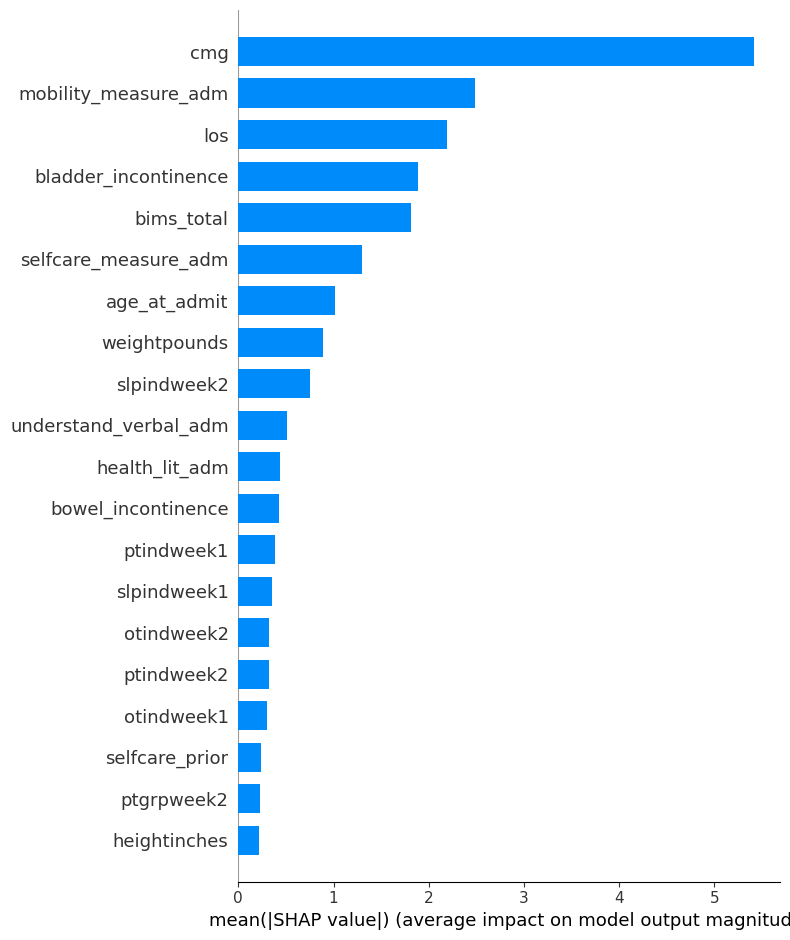

In [6]:
# shapley value test

import shap

explainer = shap.TreeExplainer(rf_regressor)

shap_values_train = explainer.shap_values(X_train)
# shap_values_eval = explainer.shap_values(X_eval)
# shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train, plot_type="bar")

MSE (w.r. previous model): 33.89382205355943
R² (w.r. previous model): 0.7931883113563027
MSE (w.r. ground truth): 320.0319760879953
R² (w.r. ground truth): 0.2873754960130982


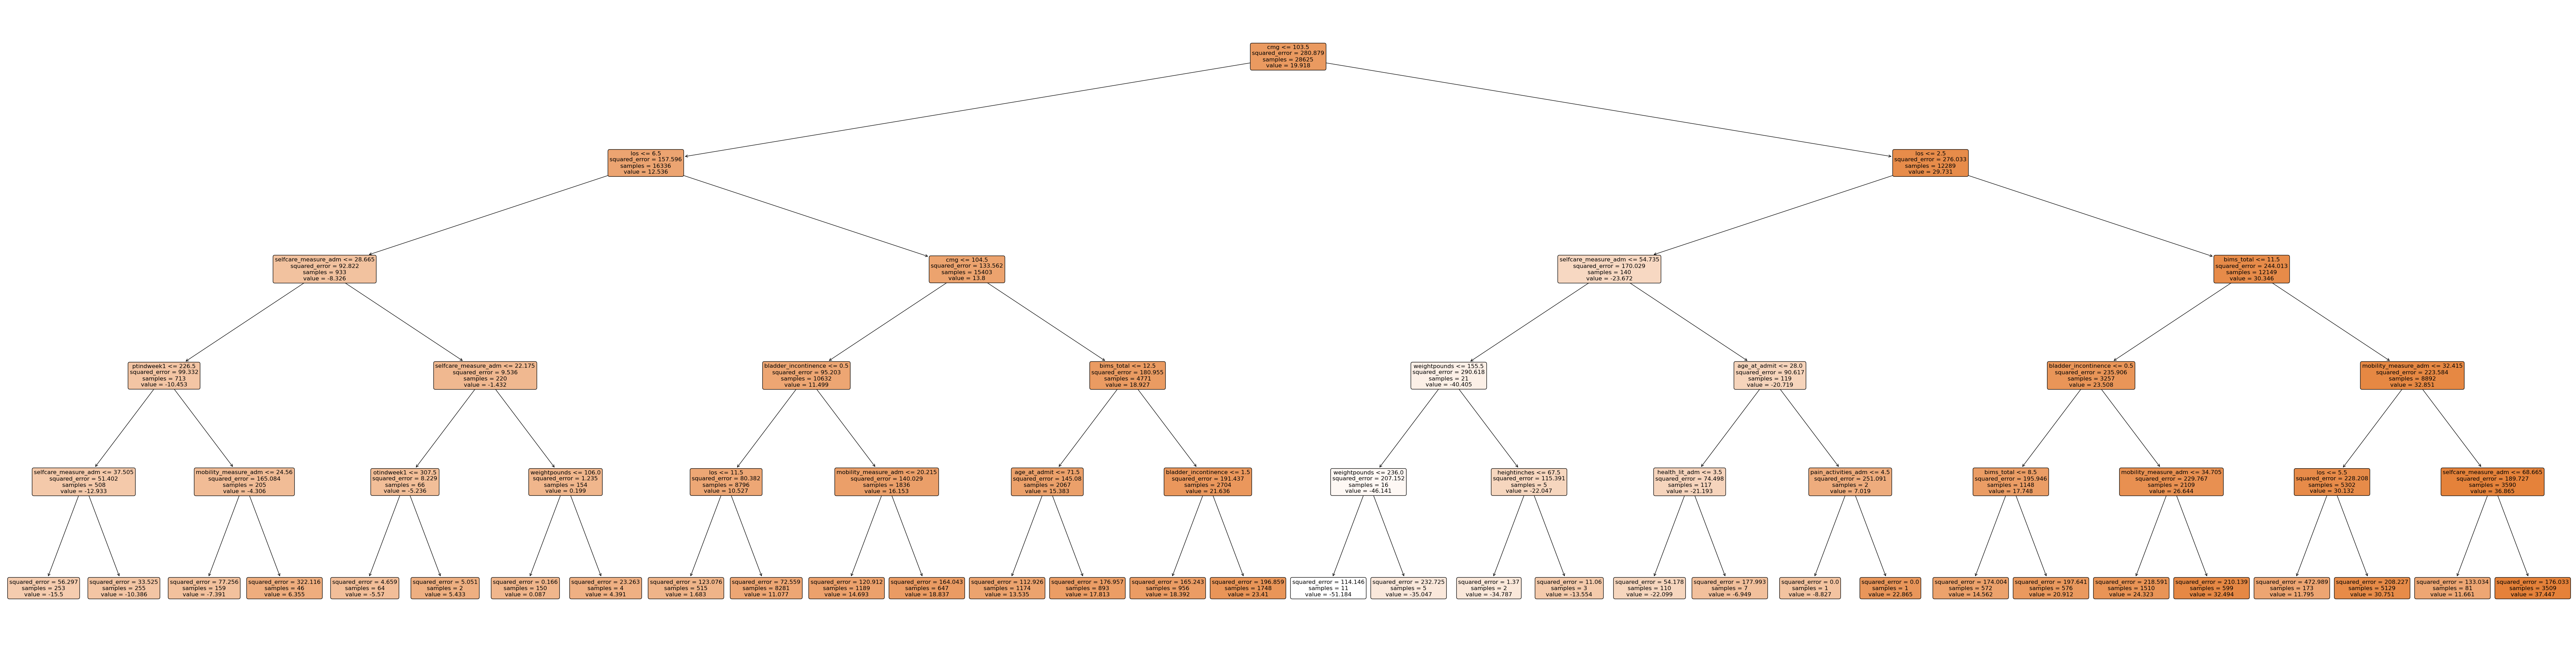

In [7]:
# regress a summary tree and visualize

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# initialize the decision tree regressor
tree_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)  # you can adjust max_depth

# train a single regression tree to previous model's output
tree_regressor.fit(X_train, y_train_pred)

# test model
y_test_pred_pred = tree_regressor.predict(X_test)
test_pred_mse = mean_squared_error(y_test_pred, y_test_pred_pred) # with previous model's output
test_pred_r2 = r2_score(y_test_pred, y_test_pred_pred)
test_mse = mean_squared_error(y_test, y_test_pred_pred) # with GT
test_r2 = r2_score(y_test, y_test_pred_pred)
print(f'MSE (w.r. previous model): {test_pred_mse}')
print(f"R² (w.r. previous model): {test_pred_r2}")
print(f'MSE (w.r. ground truth): {test_mse}')
print(f"R² (w.r. ground truth): {test_r2}")

import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import _tree

# utility func to reorder the tree so left children always smaller than right
def reorder_tree(tree, node_id):
    if tree.children_left[node_id] != _tree.TREE_LEAF: # if the current node is not a leaf node
        # get the left and right child node id's
        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]

        # get the predicted values for left and right children
        left_value = tree.value[left_child].flatten().mean()
        right_value = tree.value[right_child].flatten().mean()

        if left_value > right_value:
            # swap the children
            tree.children_left[node_id], tree.children_right[node_id] = (
                right_child,
                left_child,
            )

        # recursion
        reorder_tree(tree, left_child)
        reorder_tree(tree, right_child)

# access the tree structure
tree = tree_regressor.tree_

# reorder
reorder_tree(tree, 0)

# visualize tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(96, 24))
plot_tree(
    tree_regressor,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=12
)
plt.show()

#### 3.1.3 XGBoost

In [8]:
# xgboost

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_regressor = XGBRegressor(n_estimators=100, max_depth=6, random_state=42)

xgb_regressor.fit(X_train, y_train)

y_train_pred = xgb_regressor.predict(X_train)
y_eval_pred = xgb_regressor.predict(X_eval)
y_test_pred = xgb_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")


print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 172.1103368283956
R²: 0.6223052722068673
----------eval set results----------
MSE: 287.08650797213664
R²: 0.36651074215829726
----------test set results----------
MSE: 287.9082238930216
R²: 0.3589063888131566


In [9]:
from tabulate import tabulate

booster = xgb_regressor.get_booster()
importance_dict = booster.get_score(importance_type='gain')

importance_list = [(feature, score) for feature, score in importance_dict.items()]

importance_list = sorted(importance_list, key=lambda x: x[1], reverse=True)

print(tabulate(importance_list, headers=["Feature", "Gain"], tablefmt="pretty"))

+------------------------------------+--------------------+
|              Feature               |        Gain        |
+------------------------------------+--------------------+
|                cmg                 |   61477.91796875   |
|                los                 |  9830.7587890625   |
|           selfcare_prior           |  7957.60302734375  |
|        bladder_incontinence        |  7699.52978515625  |
|       understand_verbal_adm        |    6733.1015625    |
|             bims_total             |  6400.16455078125  |
|          wc50_type_manual          |  5626.26708984375  |
|        mobility_measure_adm        |  5535.29345703125  |
|    inattention_adm_Not_present     |  4531.5185546875   |
|            stairs_prior            |   3827.126953125   |
|        selfcare_measure_adm        |  3549.1826171875   |
|         admitclass_Unknown         |  3512.96923828125  |
|           func_cog_prior           |     3146.03125     |
|           iv_access_adm            |  

#### 3.1.4 Lasso

In [10]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

lasso_regressor = Lasso(alpha=0.01, max_iter=10000, random_state=42)

lasso_regressor.fit(X_train, y_train)

y_train_pred = lasso_regressor.predict(X_train)
y_eval_pred = lasso_regressor.predict(X_eval)
y_test_pred = lasso_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# model summary
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_regressor.coef_
})

# filter out features with zero coefficients
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(tabulate(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True), headers='keys'))


---------- Train Set Results ----------
MSE: 314.9596
R²: 0.3088
---------- Eval Set Results ----------
MSE: 305.0182
R²: 0.3269
---------- Test Set Results ----------
MSE: 312.8996
R²: 0.3033

---------- Model Summary: Non-zero Coefficients ----------
     Feature                               Coefficient
---  ----------------------------------  -------------
  0  selfcare_prior                        2.37524
  1  admitclass_Unknown                    2.09823
  2  stairs_prior                          1.40366
  3  hispanic_Yes                          1.22814
  4  admit_from_Short-term_hospital        1.14406
  5  marital_status_Unmarried              1.05907
  6  understand_verbal_adm                 1.00757
  7  payor_primary_Medicare_FFS            0.88116
  8  inattention_adm_Not_present           0.857529
  9  meds_iv_antibiotic_adm                0.817041
 10  vent_noninvasive_adm                  0.684284
 11  tier_Unknown                          0.627451
 12  sams_season     

In [11]:
# lasso with cross validation for tuning alpha
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

alpha_range = [0.001, 0.05, 0.01, 0.5, 0.1, 0.5, 1, 5, 10, 50, 100]

lasso_cv = LassoCV(alphas=alpha_range, cv=5, max_iter=10000, random_state=42)

lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

y_train_pred = lasso_cv.predict(X_train)
y_eval_pred = lasso_cv.predict(X_eval)
y_test_pred = lasso_cv.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_cv.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha found: 0.01
---------- Train Set Results ----------
MSE: 314.9596
R²: 0.3088
---------- Eval Set Results ----------
MSE: 305.0182
R²: 0.3269
---------- Test Set Results ----------
MSE: 312.8996
R²: 0.3033

---------- Model Summary: Non-zero Coefficients ----------
                            Feature  Coefficient
0                    selfcare_prior     2.375236
1                admitclass_Unknown     2.098233
2                      stairs_prior     1.403664
3                      hispanic_Yes     1.228139
4    admit_from_Short-term_hospital     1.144062
..                              ...          ...
97                    iv_access_adm    -1.749465
98                         sex_male    -1.945211
99           admitclass_Readmission    -2.114275
100                             cmg    -4.658346
101                admitclass_Other    -9.782731

[102 rows x 2 columns]


#### 3.1.5 Forward Selection

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, mean_squared_error
import pandas as pd

# ensure therapy predictors are included first
therapy_predictors = list(therapy_predictors)
remaining_features = [feature for feature in X_train.columns if feature not in therapy_predictors]

linear_model = LinearRegression()

# scoring func
scorer = make_scorer(mean_squared_error, greater_is_better=False)

sfs = SequentialFeatureSelector(
    linear_model,
    n_features_to_select="auto",  # specify an exact number of features if needed
    direction="forward",
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

sfs.fit(X_train[remaining_features], y_train)

selected_features = therapy_predictors + list(sfs.get_feature_names_out(remaining_features))

print("Selected features:", selected_features)

linear_model.fit(X_train[selected_features], y_train)

y_train_pred = linear_model.predict(X_train[selected_features])
y_eval_pred = linear_model.predict(X_eval[selected_features])
y_test_pred = linear_model.predict(X_test[selected_features])

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")


Selected features: ['ptindweek1', 'ptconweek1', 'ptgrpweek1', 'ptcoweek1', 'otindweek1', 'otconweek1', 'otgrpweek1', 'otcoweek1', 'slpindweek1', 'slpconweek1', 'slpgrpweek1', 'slpcoweek1', 'ptindweek2', 'ptconweek2', 'ptgrpweek2', 'ptcoweek2', 'otindweek2', 'otconweek2', 'otgrpweek2', 'otcoweek2', 'slpindweek2', 'slpconweek2', 'slpgrpweek2', 'slpcoweek2', 'heightinches', 'weightpounds', 'vision_adm', 'health_lit_adm', 'understand_verbal_adm', 'bims_total', 'selfcare_prior', 'mobility_prior', 'stairs_prior', 'walker_prior', 'selfcare_measure_adm', 'mobility_measure_adm', 'wc_user', 'bladder_incontinence', 'diabetes_comorbid', 'pain_therapy_adm', 'pain_activities_adm', 'nutrition_tube_adm', 'nutrition_mech_diet_adm', 'nutrition_ther_diet_adm', 'antipsychotic_ind_adm', 'anticoagulant_taking_adm', 'hypoglycemic_taking_adm', 'suctioning_adm', 'vent_cpap_adm', 'meds_iv_adm', 'meds_iv_antibiotic_adm', 'iv_access_adm', 'iv_access_periph_adm', 'iv_access_mid_adm', 'iv_access_cent_adm', 'age_at_

In [13]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.310
Model:                                OLS   Adj. R-squared:                  0.306
Method:                     Least Squares   F-statistic:                     97.52
Date:                    Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                            14:27:55   Log-Likelihood:            -1.2293e+05
No. Observations:                   28625   AIC:                         2.461e+05
Df Residuals:                       28493   BIC:                         2.472e+05
Df Model:                             131                                         
Covariance Type:                nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### 3.1.6 Interaction terms between therapy amounts and other variables

In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def add_interaction_terms(X):
    """
    Adds interaction terms between columns in therapy_predictors and all other columns.
    """
    interaction_dict = {}
    
    # Loop through therapy predictors and create interaction terms
    for therapy_col in therapy_predictors:
        if therapy_col in X.columns:
            for col in X.columns:
                # Skip interaction with itself or other therapy predictors
                if col != therapy_col and col not in therapy_predictors:
                    # Generate the interaction term name
                    interaction_term = f"{therapy_col}_x_{col}"
                    # Calculate the interaction and add to the dictionary
                    interaction_dict[interaction_term] = X[therapy_col] * X[col]
                    
    # Convert the interaction terms dictionary to a DataFrame
    interaction_df = pd.DataFrame(interaction_dict)
    
    # Concatenate the original DataFrame with the interaction terms DataFrame
    X_interactions = pd.concat([X, interaction_df], axis=1)
    
    return X_interactions


X_train_interactions = add_interaction_terms(X_train)
X_eval_interactions = add_interaction_terms(X_eval)
X_test_interactions = add_interaction_terms(X_test)

# Initialize the Linear Regressor
linear_regressor = LinearRegression()

# Fit the model on the train set
linear_regressor.fit(X_train_interactions, y_train)

# Make predictions on all sets
y_train_pred = linear_regressor.predict(X_train_interactions)
y_eval_pred = linear_regressor.predict(X_eval_interactions)
y_test_pred = linear_regressor.predict(X_test_interactions)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 275.70487960826443
R²: 0.3949678945855062
----------eval set results----------
MSE: 975.4153238046785
R²: -1.1523656194404723
----------test set results----------
MSE: 1955.2782866895197
R²: -3.35387499787008


In [15]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train_interactions)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.395
Model:                                OLS   Adj. R-squared:                  0.333
Method:                     Least Squares   F-statistic:                     6.393
Date:                    Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                            14:28:48   Log-Likelihood:            -1.2104e+05
No. Observations:                   28625   AIC:                         2.474e+05
Df Residuals:                       25972   BIC:                         2.693e+05
Df Model:                            2652                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [16]:
# lasso with cross validation for tuning alpha
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

alpha_range = [0.001, 0.05, 0.01, 0.5, 0.1, 0.5, 1, 5, 10, 50, 100]

lasso_cv = LassoCV(alphas=alpha_range, cv=5, max_iter=100000, random_state=42)

lasso_cv.fit(X_train_interactions, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

y_train_pred = lasso_cv.predict(X_train_interactions)
y_eval_pred = lasso_cv.predict(X_eval_interactions)
y_test_pred = lasso_cv.predict(X_test_interactions)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

coef_df = pd.DataFrame({
    'Feature': X_train_interactions.columns,
    'Coefficient': lasso_cv.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1781843.3082683336, tolerance: 1041.173382914618
  model = cd_fast.enet_coordinate_descent_gram(
/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34673.07602111716, tolerance: 1041.173382914618
  model = cd_fast.enet_coordinate_descent_gram(
/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3114309.7841515606, tolerance: 1041.173382914618
  model = cd_fast.enet_coordinate_descent_gram(
/Users/d9su

Best alpha found: 1.0
---------- Train Set Results ----------
MSE: 295.9540
R²: 0.3505
---------- Eval Set Results ----------
MSE: 299.7269
R²: 0.3386
---------- Test Set Results ----------
MSE: 306.7596
R²: 0.3169

---------- Model Summary: Non-zero Coefficients ----------
                                     Feature  Coefficient
0                                 otindweek1     0.818819
1                                        los     0.559554
2                                 ptindweek1     0.108843
3              otindweek2_x_admitclass_Other     0.039259
4    otgrpweek1_x_payor_primary_Medicare_FFS     0.020519
..                                       ...          ...
696                   otindweek2_x_trach_adm    -0.014006
697                  otgrpweek1_x_oxygen_adm    -0.014244
698              ptgrpweek1_x_opioid_ind_adm    -0.015871
699            ptindweek1_x_admitclass_Other    -0.020399
700            otindweek1_x_admitclass_Other    -0.040634

[701 rows x 2 columns]


/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.273e+06, tolerance: 1.304e+03
  model = cd_fast.enet_coordinate_descent(


### 3.2 Mobility

In [17]:
# drop invalid samples & split dataset

mobility_df = df.dropna(subset=["mobility_measure_delta"]).copy()

mobility_split_dict = {} # since some rows are dropped, we need to filter the split dict
for k in split_dict.keys():
    mobility_split_dict[k] = [idx for idx in split_dict[k] if idx in mobility_df.index]

mobility_train_df = mobility_df.loc[mobility_split_dict["train"]]
mobility_eval_df = mobility_df.loc[mobility_split_dict["eval"]]
mobility_test_df = mobility_df.loc[mobility_split_dict["test"]]

X_train = mobility_train_df[predictors]
y_train = mobility_train_df['mobility_measure_delta']

X_eval = mobility_eval_df[predictors]
y_eval = mobility_eval_df['mobility_measure_delta']

X_test = mobility_test_df[predictors]
y_test = mobility_test_df['mobility_measure_delta']

#### 3.2.1 Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regressor
linear_regressor = LinearRegression()

# Fit the model on the train set
linear_regressor.fit(X_train, y_train)

# Make predictions on all sets
y_train_pred = linear_regressor.predict(X_train)
y_eval_pred = linear_regressor.predict(X_eval)
y_test_pred = linear_regressor.predict(X_test)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 318.59999539912553
R²: 0.24589235618801641
----------eval set results----------
MSE: 308.57299094754353
R²: 0.26803639274231594
----------test set results----------
MSE: 310.3089095216266
R²: 0.25764499964335263


In [19]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     mobility_measure_delta   R-squared:                       0.246
Model:                                OLS   Adj. R-squared:                  0.242
Method:                     Least Squares   F-statistic:                     70.92
Date:                    Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                            22:01:18   Log-Likelihood:            -1.2311e+05
No. Observations:                   28625   AIC:                         2.465e+05
Df Residuals:                       28493   BIC:                         2.476e+05
Df Model:                             131                                         
Covariance Type:                nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### 3.2.2 Random Forest

In [20]:
# RF

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model on the train set
rf_regressor.fit(X_train, y_train)

# make predictions on all sets
y_train_pred = rf_regressor.predict(X_train)
y_eval_pred = rf_regressor.predict(X_eval)
y_test_pred = rf_regressor.predict(X_test)

# train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")


print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 41.118095361545485
R²: 0.9026758617108988
----------eval set results----------
MSE: 287.6397945636445
R²: 0.3176918661184578
----------test set results----------
MSE: 284.739322889089
R²: 0.31881536862495574


In [ ]:
# shapley value test

import shap

explainer = shap.TreeExplainer(rf_regressor)

shap_values_train = explainer.shap_values(X_train)
# shap_values_eval = explainer.shap_values(X_eval)
# shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train, plot_type="bar")

MSE (w.r. previous model): 31.778490783424427
R² (w.r. previous model): 0.7649109056070784
MSE (w.r. ground truth): 314.9766489133854
R² (w.r. ground truth): 0.24647832162828798


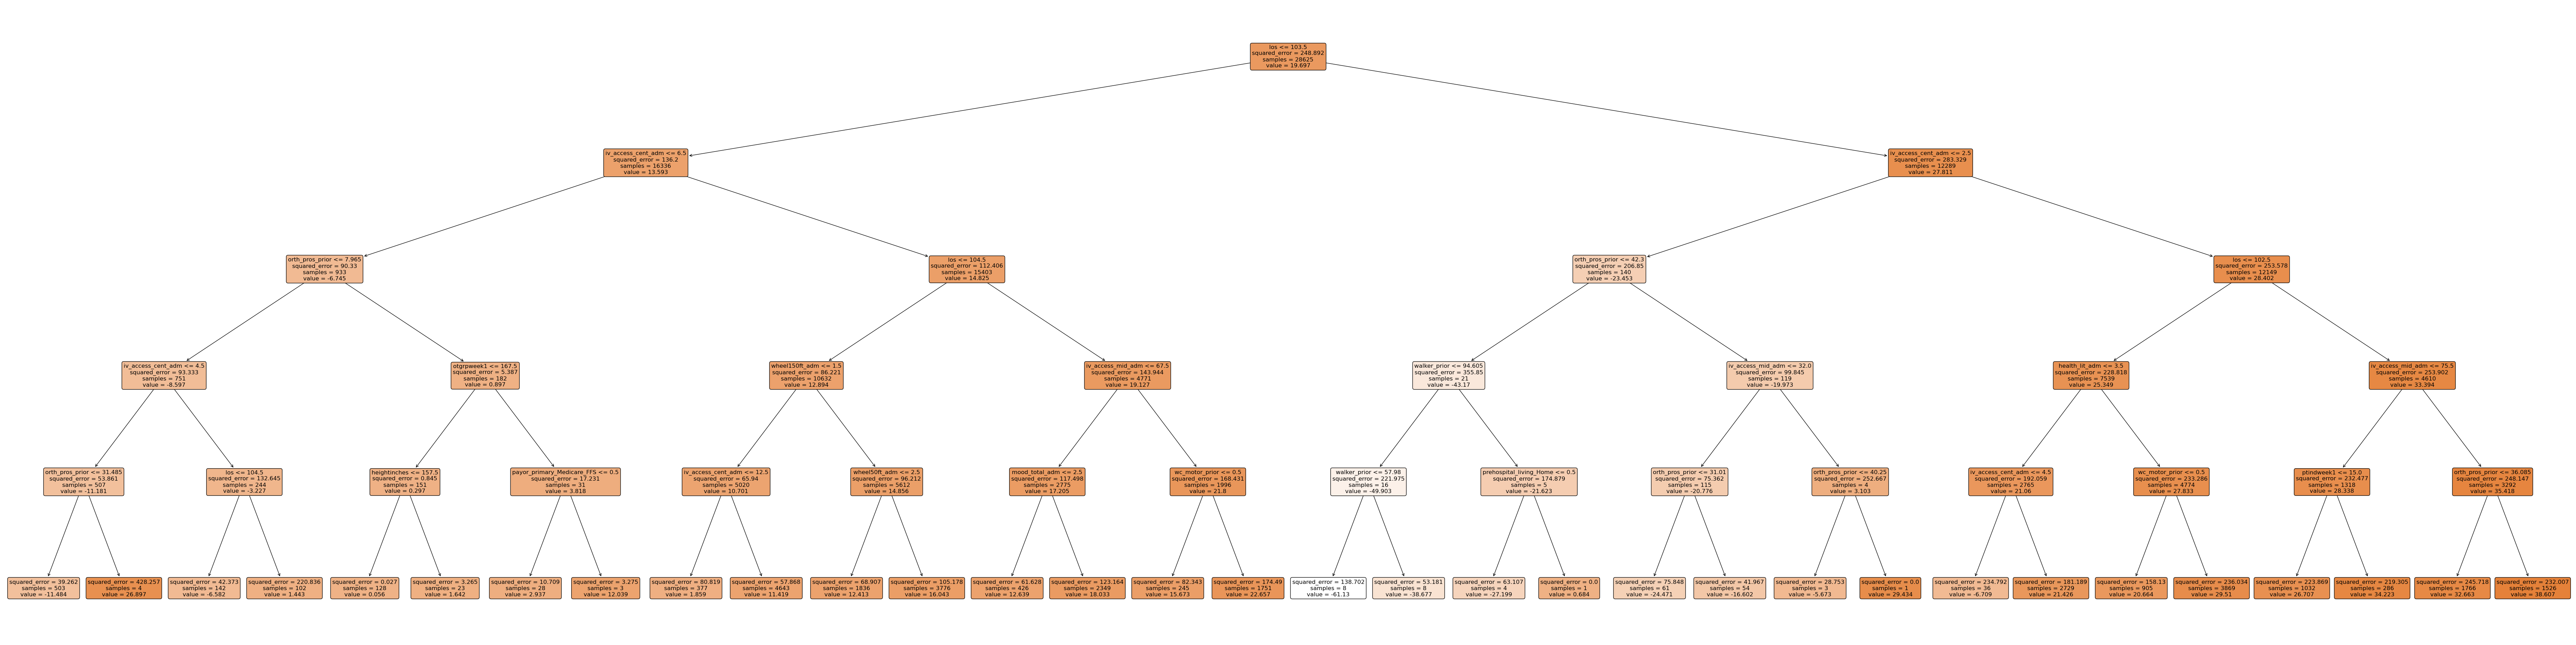

In [ ]:
# regress a summary tree and visualize

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# initialize the decision tree regressor
tree_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)  # you can adjust max_depth

# train a single regression tree to previous model's output
tree_regressor.fit(X_train, y_train_pred)

# test model
y_test_pred_pred = tree_regressor.predict(X_test)
test_pred_mse = mean_squared_error(y_test_pred, y_test_pred_pred) # with previous model's output
test_pred_r2 = r2_score(y_test_pred, y_test_pred_pred)
test_mse = mean_squared_error(y_test, y_test_pred_pred) # with GT
test_r2 = r2_score(y_test, y_test_pred_pred)
print(f'MSE (w.r. previous model): {test_pred_mse}')
print(f"R² (w.r. previous model): {test_pred_r2}")
print(f'MSE (w.r. ground truth): {test_mse}')
print(f"R² (w.r. ground truth): {test_r2}")

import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import _tree

# utility func to reorder the tree so left children always smaller than right
def reorder_tree(tree, node_id):
    if tree.children_left[node_id] != _tree.TREE_LEAF: # if the current node is not a leaf node
        # get the left and right child node id's
        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]

        # get the predicted values for left and right children
        left_value = tree.value[left_child].flatten().mean()
        right_value = tree.value[right_child].flatten().mean()

        if left_value > right_value:
            # swap the children
            tree.children_left[node_id], tree.children_right[node_id] = (
                right_child,
                left_child,
            )

        # recursion
        reorder_tree(tree, left_child)
        reorder_tree(tree, right_child)

# access the tree structure
tree = tree_regressor.tree_

# reorder
reorder_tree(tree, 0)

# visualize tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(96, 24))
plot_tree(
    tree_regressor,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=12
)
plt.show()

#### 3.2.3 XGBoost

In [ ]:
# xgboost

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_regressor = XGBRegressor(n_estimators=100, max_depth=6, random_state=42)

xgb_regressor.fit(X_train, y_train)

y_train_pred = xgb_regressor.predict(X_train)
y_eval_pred = xgb_regressor.predict(X_eval)
y_test_pred = xgb_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")


print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 173.4110061016436
R²: 0.589546242590012
----------eval set results----------
MSE: 287.2631749939619
R²: 0.3185852424892872
----------test set results----------
MSE: 286.6289665219431
R²: 0.31429475591710954


In [ ]:
from tabulate import tabulate

booster = xgb_regressor.get_booster()
importance_dict = booster.get_score(importance_type='gain')

importance_list = [(feature, score) for feature, score in importance_dict.items()]

importance_list = sorted(importance_list, key=lambda x: x[1], reverse=True)

print(tabulate(importance_list, headers=["Feature", "Gain"], tablefmt="pretty"))

+------------------------------------+--------------------+
|              Feature               |        Gain        |
+------------------------------------+--------------------+
|                cmg                 |    36974.703125    |
|                los                 |  10005.494140625   |
|            walker_prior            |   9613.53515625    |
|           selfcare_prior           |  6996.55126953125  |
|       understand_verbal_adm        |  6210.3173828125   |
|           mobility_prior           |  6172.7880859375   |
|          wc_manual_prior           |   5560.912109375   |
|        bladder_incontinence        |  5547.4111328125   |
|    inattention_adm_Not_present     |  4951.9423828125   |
|        selfcare_measure_adm        |   4462.583984375   |
|         bowel_incontinence         |  4340.2763671875   |
|       admitclass_Readmission       |   4207.72265625    |
|             sams_hosp              |  4100.63720703125  |
|           iv_access_adm            | 3

#### 3.2.4 Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

lasso_regressor = Lasso(alpha=0.01, max_iter=10000, random_state=42)

lasso_regressor.fit(X_train, y_train)

y_train_pred = lasso_regressor.predict(X_train)
y_eval_pred = lasso_regressor.predict(X_eval)
y_test_pred = lasso_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# model summary
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_regressor.coef_
})

# filter out features with zero coefficients
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(tabulate(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True), headers='keys'))


---------- Train Set Results ----------
MSE: 318.5434
R²: 0.2460
---------- Eval Set Results ----------
MSE: 307.8166
R²: 0.2698
---------- Test Set Results ----------
MSE: 309.6373
R²: 0.2593

---------- Model Summary: Non-zero Coefficients ----------
     Feature                           Coefficient
---  ------------------------------  -------------
  0  admit_from_Short-term_hospital    2.64211
  1  race_Asian_Indian                 1.95971
  2  hispanic_Yes                      1.51074
  3  tier_Unknown                      1.3215
  4  stairs_prior                      1.23316
  5  selfcare_prior                    1.19094
  6  admitclass_Unknown                1.19048
  7  payor_primary_Not_listed          1.0454
  8  vent_noninvasive_adm              1.01918
  9  understand_verbal_adm             0.746554
 10  payor_primary_Medicare_FFS        0.671067
 11  tier_3                            0.642546
 12  drug_regimen_review_Yes           0.615802
 13  marital_status_Unmarried   

#### 3.2.5 Forward Selection

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, mean_squared_error
import pandas as pd

# ensure therapy predictors are included first
therapy_predictors = list(therapy_predictors)
remaining_features = [feature for feature in X_train.columns if feature not in therapy_predictors]

linear_model = LinearRegression()

# scoring func
scorer = make_scorer(mean_squared_error, greater_is_better=False)

sfs = SequentialFeatureSelector(
    linear_model,
    n_features_to_select="auto",  # specify an exact number of features if needed
    direction="forward",
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

sfs.fit(X_train[remaining_features], y_train)

selected_features = therapy_predictors + list(sfs.get_feature_names_out(remaining_features))

print("Selected features:", selected_features)

linear_model.fit(X_train[selected_features], y_train)

y_train_pred = linear_model.predict(X_train[selected_features])
y_eval_pred = linear_model.predict(X_eval[selected_features])
y_test_pred = linear_model.predict(X_test[selected_features])

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")


Selected features: ['ptindweek1', 'ptconweek1', 'ptgrpweek1', 'ptcoweek1', 'otindweek1', 'otconweek1', 'otgrpweek1', 'otcoweek1', 'slpindweek1', 'slpconweek1', 'slpgrpweek1', 'slpcoweek1', 'ptindweek2', 'ptconweek2', 'ptgrpweek2', 'ptcoweek2', 'otindweek2', 'otconweek2', 'otgrpweek2', 'otcoweek2', 'slpindweek2', 'slpconweek2', 'slpgrpweek2', 'slpcoweek2', 'heightinches', 'weightpounds', 'vision_adm', 'health_lit_adm', 'understand_verbal_adm', 'bims_total', 'selfcare_prior', 'mobility_prior', 'stairs_prior', 'walker_prior', 'selfcare_measure_adm', 'mobility_measure_adm', 'wc_user', 'bladder_incontinence', 'diabetes_comorbid', 'pain_therapy_adm', 'pain_activities_adm', 'nutrition_tube_adm', 'nutrition_mech_diet_adm', 'nutrition_ther_diet_adm', 'antipsychotic_ind_adm', 'anticoagulant_taking_adm', 'hypoglycemic_taking_adm', 'suctioning_adm', 'vent_cpap_adm', 'meds_iv_adm', 'meds_iv_antibiotic_adm', 'iv_access_adm', 'iv_access_periph_adm', 'iv_access_mid_adm', 'iv_access_cent_adm', 'age_at_

In [ ]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.310
Model:                                OLS   Adj. R-squared:                  0.306
Method:                     Least Squares   F-statistic:                     97.52
Date:                    Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                            04:56:44   Log-Likelihood:            -1.2293e+05
No. Observations:                   28625   AIC:                         2.461e+05
Df Residuals:                       28493   BIC:                         2.472e+05
Df Model:                             131                                         
Covariance Type:                nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### 3.2.6 Interaction terms between therapy amounts and other variables

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def add_interaction_terms(X):
    """
    Adds interaction terms between columns in therapy_predictors and all other columns.
    """
    interaction_dict = {}
    
    # Loop through therapy predictors and create interaction terms
    for therapy_col in therapy_predictors:
        if therapy_col in X.columns:
            for col in X.columns:
                # Skip interaction with itself or other therapy predictors
                if col != therapy_col and col not in therapy_predictors:
                    # Generate the interaction term name
                    interaction_term = f"{therapy_col}_x_{col}"
                    # Calculate the interaction and add to the dictionary
                    interaction_dict[interaction_term] = X[therapy_col] * X[col]
                    
    # Convert the interaction terms dictionary to a DataFrame
    interaction_df = pd.DataFrame(interaction_dict)
    
    # Concatenate the original DataFrame with the interaction terms DataFrame
    X_interactions = pd.concat([X, interaction_df], axis=1)
    
    return X_interactions


X_train_interactions = add_interaction_terms(X_train)
X_eval_interactions = add_interaction_terms(X_eval)
X_test_interactions = add_interaction_terms(X_test)

# Initialize the Linear Regressor
linear_regressor = LinearRegression()

# Fit the model on the train set
linear_regressor.fit(X_train_interactions, y_train)

# Make predictions on all sets
y_train_pred = linear_regressor.predict(X_train_interactions)
y_eval_pred = linear_regressor.predict(X_eval_interactions)
y_test_pred = linear_regressor.predict(X_test_interactions)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 275.70487960826443
R²: 0.3949678945855062
----------eval set results----------
MSE: 975.4153238046785
R²: -1.1523656194404723
----------test set results----------
MSE: 1955.2782866895197
R²: -3.35387499787008


In [ ]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train_interactions)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.395
Model:                                OLS   Adj. R-squared:                  0.333
Method:                     Least Squares   F-statistic:                     6.393
Date:                    Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                            05:08:33   Log-Likelihood:            -1.2104e+05
No. Observations:                   28625   AIC:                         2.474e+05
Df Residuals:                       25972   BIC:                         2.693e+05
Df Model:                            2652                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [ ]:
# lasso with cross validation for tuning alpha
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

alpha_range = [0.001, 0.05, 0.01, 0.5, 0.1, 0.5, 1, 5, 10, 50, 100]

lasso_cv = LassoCV(alphas=alpha_range, cv=5, max_iter=100000, random_state=42)

lasso_cv.fit(X_train_interactions, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

y_train_pred = lasso_cv.predict(X_train_interactions)
y_eval_pred = lasso_cv.predict(X_eval_interactions)
y_test_pred = lasso_cv.predict(X_test_interactions)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

coef_df = pd.DataFrame({
    'Feature': X_train_interactions.columns,
    'Coefficient': lasso_cv.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31080.904596061446, tolerance: 1041.173382914618
  model = cd_fast.enet_coordinate_descent_gram(
/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3215595.8949261596, tolerance: 1041.173382914618
  model = cd_fast.enet_coordinate_descent_gram(
/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3152834.097158288, tolerance: 1041.173382914618
  model = cd_fast.enet_coordinate_descent_gram(
/Users/d9su

KeyboardInterrupt: 